In [127]:
! pip install torch torchvision wandb

In [1]:
import torchvision
import torch
from torchvision import transforms, datasets
from torch.utils.data import Subset, DataLoader, TensorDataset, Dataset
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import os
import cv2
import scipy.io
import wandb
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU available:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("No GPU available, using CPU.")

GPU available: Tesla P100-PCIE-16GB


# Task 4: CNN and AutoEncoders

#### Data processing: 

In [5]:
img_path = './images/'
transform = transforms.Compose([
    transforms.ToTensor()
])

In [6]:
mnist_dataset = datasets.MNIST(root=img_path, train=True, transform=transform, download=True)
mnist_val_dataset = Subset(mnist_dataset, torch.arange(0, 10000))
mnist_train_dataset = Subset(mnist_dataset, torch.arange(10000, len(mnist_dataset)))
mnist_test_dataset = torchvision.datasets.MNIST(root=img_path, train=False, transform=transform, download=False)

In [5]:
batch_size = 64
torch.manual_seed(42)

train_ = DataLoader(mnist_train_dataset, batch_size=batch_size, shuffle=True)
val_ = DataLoader(mnist_val_dataset, batch_size=batch_size, shuffle=False)

In [6]:
# size of each image
mnist_train_dataset[1][1]

8

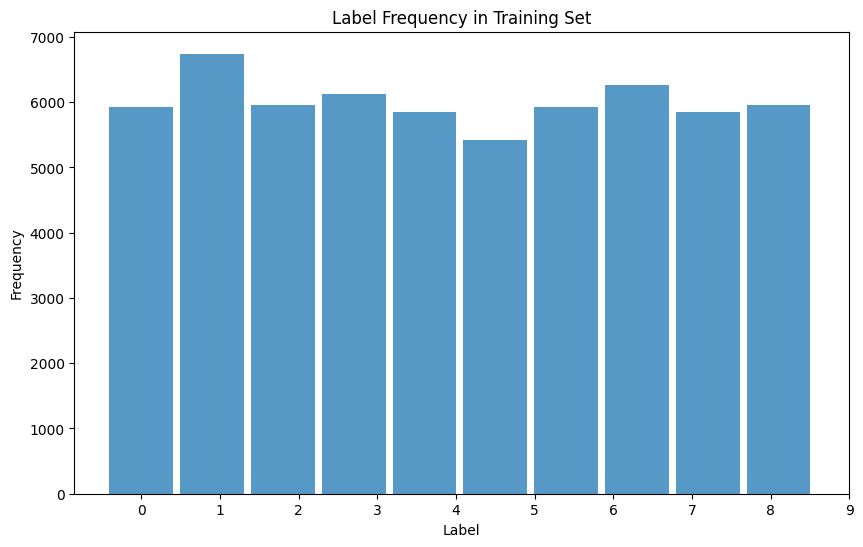

In [7]:
labels = mnist_train_dataset.dataset.targets
plt.figure(figsize=(10, 6))
plt.hist(labels, bins=10, rwidth=0.9, alpha=0.75, align='left')
plt.xticks(range(10))
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Label Frequency in Training Set')
plt.show()


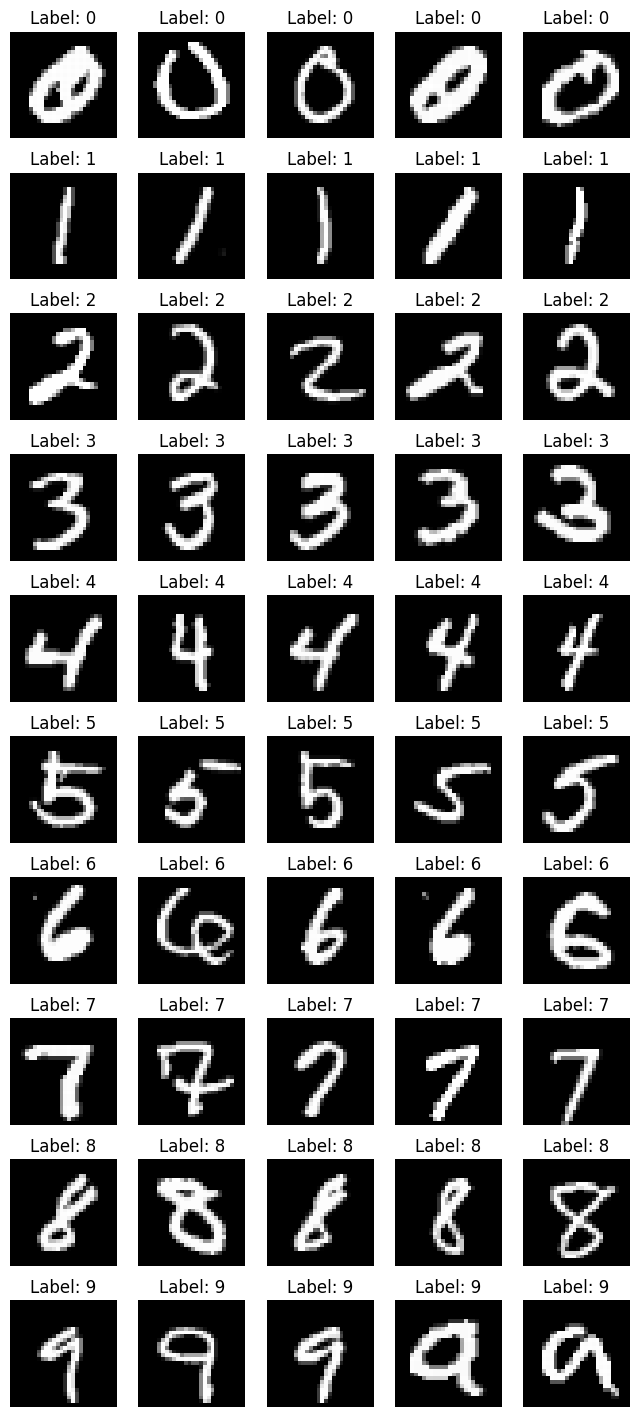

In [8]:
class_samples = {}
num_samples_per_class = 5

for i in range(10):
    class_samples[i] = []

for i in range(len(mnist_train_dataset)):
    image, label = mnist_train_dataset[i]
    if(len(class_samples[label]) < num_samples_per_class):
        class_samples[label].append(image)

fig, ax = plt.subplots(10, num_samples_per_class, figsize=(8, 18))
for i in range(10):
    for j in range(num_samples_per_class):
        ax[i, j].imshow(class_samples[i][j].squeeze().numpy(), cmap='gray')
        ax[i, j].set_title(f"Label: {i}")
        ax[i, j].axis('off')
plt.show()

In [9]:
# to get the feature maps of the desired layer
def get_interested_layer(layer_name, model):
    layer_ = dict(model.named_children())
    if layer_name not in layer_:
        raise ValueError(f'Invalid layer name, available layer names are: {list(layer_.keys())}')
    return layer_[layer_name]

def visualized_feature_maps(model, layer_name, input_image):
    model.eval()

    layer = get_interested_layer(layer_name, model)
    print(layer)
    feature_maps = None
    def hook_fn(_, __, output):
        nonlocal feature_maps
        feature_maps = output

    hook = layer.register_forward_hook(hook_fn)
    print(hook)

    with torch.no_grad():
        model(input_image.to(device))

    hook.remove()

    num_channels = feature_maps.shape[1]
    num_channels = min(5, num_channels)
    fig, axes = plt.subplots(1, num_channels, figsize=(12, 4))   

    for i in range(num_channels):
        feature_map = feature_maps[0, i]
        axes[i].imshow(feature_map.cpu(), cmap='gray')
        axes[i].set_title(f'Feature Map {i}')
        axes[i].axis('off')

    # plt.show()

#### CNN Model

In [10]:
class CNN(nn.Module):
    def __init__(self, train, val, batch_size=32, learning_rate = 0.001, kernel_size = 5, strides = 1, max_epochs = 10, dropout_rate = 0.5, num_classes = 10, input_channels = 1, verbose= True):
        super(CNN, self).__init__()
        self.batch_size = batch_size
        self.train_dl = DataLoader(train, batch_size=self.batch_size, shuffle=True)
        self.val_dl = DataLoader(val, batch_size=self.batch_size, shuffle=False)
        self.learning_rate = learning_rate
        self.kernel_size = kernel_size
        self.strides = strides
        self.max_epochs = max_epochs
        self.dropout_rate = dropout_rate
        self.input_channels = input_channels
        self.num_classes = num_classes
        self.verbose = verbose

    def _get_features_size(self, input_channels):
        # A helper function to compute the number of features after the convolutional layers
        with torch.no_grad():
            x = torch.zeros(1, input_channels, 28, 28)
            x = self.model[:6](x)
            return x.view(x.size(0), -1).shape[1]

    def fit(self):
        self.model = nn.Sequential()
        self.model.add_module('conv1', nn.Conv2d(in_channels=self.input_channels, out_channels=32, kernel_size=self.kernel_size, stride=self.strides, padding=2))
        self.model.add_module('relu1', nn.ReLU())
        self.model.add_module('pool1', nn.MaxPool2d(kernel_size=2))
        self.model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=self.kernel_size, stride=self.strides, padding=2))
        self.model.add_module('relu2', nn.ReLU())
        self.model.add_module('pool2', nn.MaxPool2d(kernel_size=2))
        self.model.add_module('flatten', nn.Flatten())

        self.feature_size = self._get_features_size(self.input_channels)

        self.model.add_module('fc1', nn.Linear(self.feature_size, 1024))
        self.model.add_module('relu3', nn.ReLU())
        self.model.add_module('dropout', nn.Dropout(self.dropout_rate))
        self.model.add_module('fc2', nn.Linear(1024, self.num_classes))

        self.loss_fn = nn.CrossEntropyLoss()
        self.optimiser = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

    def predict(self, x):
        self.model.eval()
        with torch.no_grad():
            x = torch.tensor(x, dtype=torch.float32)
            x = x.to(device)
            y_pred = self.model(x)
#             print(y_pred)
            return torch.argmax(y_pred, dim=1)


    def train(self):
        train_accuracy = [0] * self.max_epochs
        train_loss = [0] * self.max_epochs
        val_accuracy = [0] * self.max_epochs
        val_loss = [0] * self.max_epochs

        self.model = self.model.to(device)
        for epoch in range(self.max_epochs):
            self.model.train()
            for x_batch, y_batch in self.train_dl:
#                 print(x_batch.shape)
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                y_pred = self.model(x_batch)
                loss = self.loss_fn(y_pred, y_batch)
                loss.backward()
                self.optimiser.step()
                self.optimiser.zero_grad()

                
                train_loss[epoch] += loss.item()*y_batch.size(0)
                correct_pred = (torch.argmax(y_pred, dim=1) == y_batch).float()
                train_accuracy[epoch] += correct_pred.sum().cpu()

            train_loss[epoch] /= len(self.train_dl.dataset)
            train_accuracy[epoch] /= len(self.train_dl.dataset)

            self.model.eval()

            with torch.no_grad():
                for x_batch, y_batch in self.val_dl:
                    x_batch = x_batch.to(device)
                    y_batch = y_batch.to(device)
                    y_pred = self.model(x_batch)
                    loss = self.loss_fn(y_pred, y_batch)
                    val_loss[epoch] += loss.item()*y_batch.size(0)
                    correct_pred = (torch.argmax(y_pred, dim=1) == y_batch).float()
                    val_accuracy[epoch] += correct_pred.sum().cpu()
                
                val_loss[epoch] /= len(self.val_dl.dataset)
                val_accuracy[epoch] /= len(self.val_dl.dataset)
            
            if(self.verbose):
                print(f'Epoch {epoch+1}/{self.max_epochs}: accuracy: {train_accuracy[epoch]:.4f}, loss: {train_loss[epoch]:.4f}, val_accuracy: {val_accuracy[epoch]:.4f}, val_loss: {val_loss[epoch]:.4f}')

        return train_loss, train_accuracy, val_loss, val_accuracy
    
    def get_model(self):
        return self.model

In [11]:
cnn_model = CNN(mnist_train_dataset, mnist_val_dataset, batch_size=64)
# cnn_model = cnn_model.to('cuda')
cnn_model.fit()
hist = cnn_model.train()

Epoch 1/10: accuracy: 0.9511, loss: 0.1604, val_accuracy: 0.9826, val_loss: 0.0550
Epoch 2/10: accuracy: 0.9851, loss: 0.0475, val_accuracy: 0.9819, val_loss: 0.0606
Epoch 3/10: accuracy: 0.9890, loss: 0.0344, val_accuracy: 0.9877, val_loss: 0.0374
Epoch 4/10: accuracy: 0.9922, loss: 0.0238, val_accuracy: 0.9889, val_loss: 0.0388
Epoch 5/10: accuracy: 0.9938, loss: 0.0193, val_accuracy: 0.9897, val_loss: 0.0347
Epoch 6/10: accuracy: 0.9948, loss: 0.0170, val_accuracy: 0.9877, val_loss: 0.0457
Epoch 7/10: accuracy: 0.9947, loss: 0.0154, val_accuracy: 0.9873, val_loss: 0.0475
Epoch 8/10: accuracy: 0.9967, loss: 0.0111, val_accuracy: 0.9904, val_loss: 0.0359
Epoch 9/10: accuracy: 0.9965, loss: 0.0108, val_accuracy: 0.9904, val_loss: 0.0411
Epoch 10/10: accuracy: 0.9970, loss: 0.0087, val_accuracy: 0.9898, val_loss: 0.0385


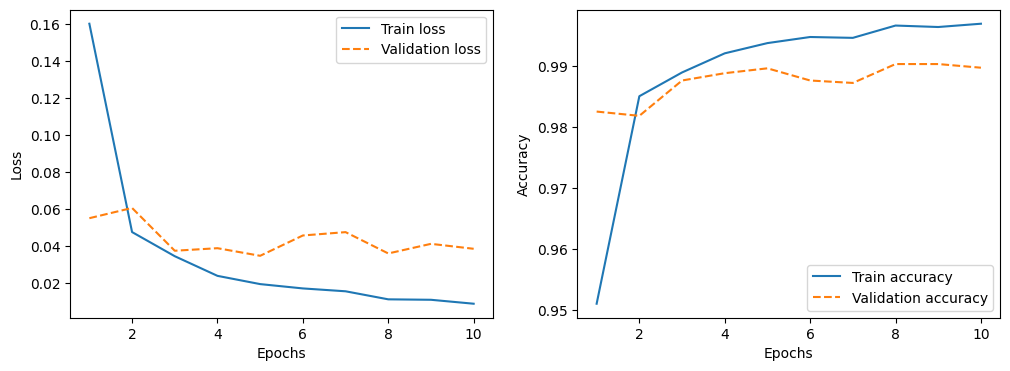

In [12]:
x_axis = np.arange(len(hist[0])) + 1
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_axis, hist[0], linestyle='-', label='Train loss')
ax.plot(x_axis, hist[2], linestyle='--', label='Validation loss')
ax.legend()
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_axis, hist[1], linestyle='-', label = 'Train accuracy')
ax.plot(x_axis, hist[3], linestyle='--', label = 'Validation accuracy')
ax.legend()
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
plt.show()


torch.Size([1, 1, 28, 28])
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


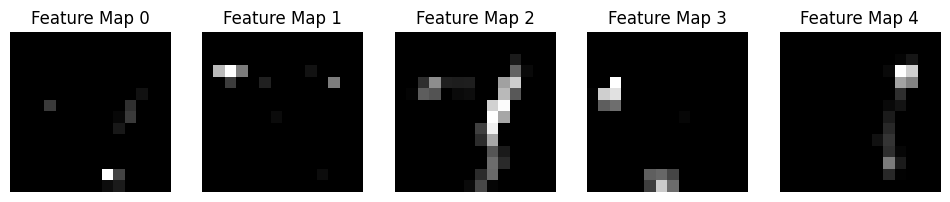

In [19]:
layer_name = 'pool1'
input_image = mnist_train_dataset[2][0]
input_image = input_image.unsqueeze(0)
print(input_image.shape)

visualized_feature_maps(model=cnn_model.model, layer_name=layer_name, input_image=input_image)

The feature maps reveal distinctive visual patterns related to the class, such as edges or shapes. The CNN exhibits a hierarchical feature extraction process, with deeper layers capturing more complex class-related elements. Pooling layers help retain important information while reducing spatial dimensions. As we go deeper in the networks the feature maps become complex and harder to interpret directly.

#### Hyperparameter Tuning

In [ ]:
sweep_configuration = {
    "method": "random",
    "name": "sweep",
    "metric": {"goal": "maximize", "name": "accuracy"},
    "parameters": {
        "epochs": {"values": [20, 15, 10]},
        "lr": {"values": [0.0001, 0.00025, 0.0005, 0.001, 0.005]},
        "batch_size": {"values": [32, 64, 128, 256]},
        "kernel_size": {"values": [1, 3, 5, 7]},
        "strides": {"values": [1, 2, 3]},
        "dropout_rate": {"values": [0.25, 0.5, 0.75]}
    },
}

sweep_id = wandb.sweep(sweep=sweep_configuration, project="4.3-CNN-classification")

def tuning():
    run = wandb.init()

    lr = wandb.config.lr
    epochs = wandb.config.epochs
    batch_size = wandb.config.batch_size
    kernel_size = wandb.config.kernel_size
    strides = wandb.config.strides
    dropout_rate = wandb.config.dropout_rate

    # for epoch in np.arange(epochs-10, epochs):
    model = CNN(mnist_train_dataset, mnist_val_dataset, batch_size=batch_size, learning_rate = lr, kernel_size = kernel_size, strides = strides, max_epochs = epochs, dropout_rate = dropout_rate, num_classes = 10, input_channels = 1, verbose= False)

    model.fit()
    hist = model.train()
    # accuracies, losses, v_epochs = regression_model.get_metric_for_each_epoch()
    accuracies = hist[3]
    losses = hist[2]
    v_epochs = range(1, epochs+1)
    for accuracy, loss, epoch_count in zip(accuracies, losses, v_epochs):
        wandb.log({"accuracy": accuracy, "loss": loss})

wandb.agent(sweep_id, function=tuning, count=20)

The link to my wandb report for logging loss and accuracy:
https://api.wandb.ai/links/anushka-agrawal/jf4kzt6t

### running the model with 0 dropout rate

Epoch 1/10: accuracy: 0.9480, loss: 0.1622, val_accuracy: 0.9791, val_loss: 0.0728
Epoch 2/10: accuracy: 0.9860, loss: 0.0446, val_accuracy: 0.9854, val_loss: 0.0454
Epoch 3/10: accuracy: 0.9903, loss: 0.0297, val_accuracy: 0.9868, val_loss: 0.0432
Epoch 4/10: accuracy: 0.9933, loss: 0.0203, val_accuracy: 0.9881, val_loss: 0.0411
Epoch 5/10: accuracy: 0.9951, loss: 0.0149, val_accuracy: 0.9893, val_loss: 0.0378
Epoch 6/10: accuracy: 0.9953, loss: 0.0133, val_accuracy: 0.9883, val_loss: 0.0481
Epoch 7/10: accuracy: 0.9969, loss: 0.0095, val_accuracy: 0.9891, val_loss: 0.0469
Epoch 8/10: accuracy: 0.9974, loss: 0.0080, val_accuracy: 0.9894, val_loss: 0.0458
Epoch 9/10: accuracy: 0.9974, loss: 0.0081, val_accuracy: 0.9867, val_loss: 0.0519
Epoch 10/10: accuracy: 0.9977, loss: 0.0072, val_accuracy: 0.9867, val_loss: 0.0594


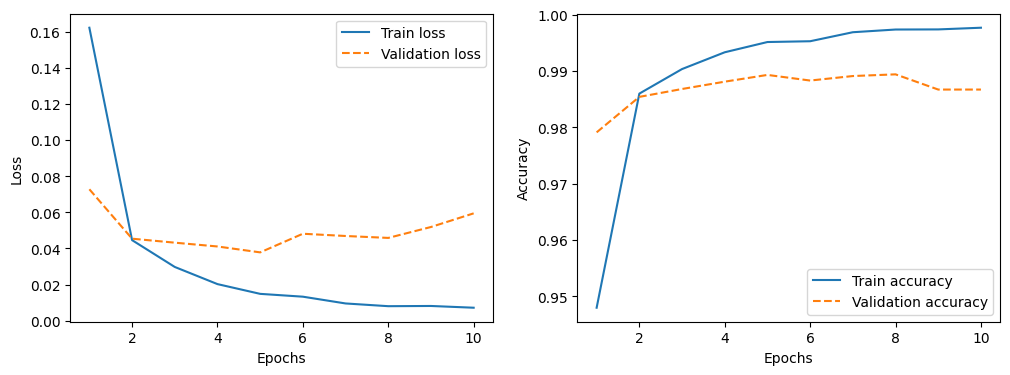

In [14]:
cnn_model = CNN(mnist_train_dataset, mnist_val_dataset, batch_size=128, dropout_rate = 0.0)
# cnn_model = cnn_model.to('cuda')
cnn_model.fit()
hist = cnn_model.train()

x_axis = np.arange(len(hist[0])) + 1
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_axis, hist[0], linestyle='-', label='Train loss')
ax.plot(x_axis, hist[2], linestyle='--', label='Validation loss')
ax.legend()
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_axis, hist[1], linestyle='-', label = 'Train accuracy')
ax.plot(x_axis, hist[3], linestyle='--', label = 'Validation accuracy')
ax.legend()
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
plt.show()

 - **Comparing the effect of using and not using dropout layers**
 
**Using Dropout Layers in a CNN**:
When dropout layers are included into a CNN, several advantages can be seen. Firstly, dropout acts as a regularization technique, helping to mitigate overfitting by randomly deactivating a portion of neurons during training. This regularization contributes to improved generalization, making the model more adept at handling unseen data. Additionally, dropout can be likened to creating an ensemble of multiple sub-networks within the model, which, during inference, collaborate to provide more robust and accurate predictions. By encouraging the network to learn more generalized and robust features, dropout aids in adaptability to diverse data distributions.

**Not Using Dropout Layers in a CNN**:
Conversely, opting not to include dropout layers in a CNN may result in some drawbacks. Most notably, the model becomes more susceptible to overfitting, particularly when working with limited training data or a complex architecture. In such cases, the model might perform well on the training data but struggle with unseen data. Without dropout, there's also an increased risk of neurons becoming overly specialized in learning specific patterns, which can hinder model generalization. Furthermore, training a CNN without dropout might require careful tuning of other hyperparameters, and it could take longer to converge to a satisfactory solution.

In [20]:
cnn_model = CNN(mnist_train_dataset, mnist_val_dataset, batch_size=128, learning_rate=0.00025, kernel_size=7, strides = 1, dropout_rate=0.75)
# cnn_model = cnn_model.to('cuda')
cnn_model.fit()
hist = cnn_model.train()

Epoch 1/10: accuracy: 0.8774, loss: 0.4050, val_accuracy: 0.9668, val_loss: 0.1159
Epoch 2/10: accuracy: 0.9661, loss: 0.1119, val_accuracy: 0.9807, val_loss: 0.0677
Epoch 3/10: accuracy: 0.9763, loss: 0.0781, val_accuracy: 0.9822, val_loss: 0.0607
Epoch 4/10: accuracy: 0.9810, loss: 0.0625, val_accuracy: 0.9839, val_loss: 0.0516
Epoch 5/10: accuracy: 0.9835, loss: 0.0524, val_accuracy: 0.9874, val_loss: 0.0427
Epoch 6/10: accuracy: 0.9859, loss: 0.0452, val_accuracy: 0.9882, val_loss: 0.0422
Epoch 7/10: accuracy: 0.9877, loss: 0.0382, val_accuracy: 0.9884, val_loss: 0.0400
Epoch 8/10: accuracy: 0.9890, loss: 0.0345, val_accuracy: 0.9885, val_loss: 0.0387
Epoch 9/10: accuracy: 0.9905, loss: 0.0301, val_accuracy: 0.9900, val_loss: 0.0365
Epoch 10/10: accuracy: 0.9916, loss: 0.0264, val_accuracy: 0.9893, val_loss: 0.0379


In [26]:
test_dl = DataLoader(mnist_test_dataset, batch_size=128, shuffle=True)

test_accuracy = 0
all_true_labels = []
all_predicted_labels = []

for x_batch, y_batch in test_dl:
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    y_pred = cnn_model.predict(x_batch)
    test_accuracy += (y_pred == y_batch).sum().item()
    all_true_labels.extend(y_batch.tolist())
    all_predicted_labels.extend(y_pred.tolist())

test_accuracy /= len(test_dl.dataset)

class_names = [str(i) for i in range(10)]  # Assuming 10 classes
print("Test Accuracy:", test_accuracy)
print(classification_report(all_true_labels, all_predicted_labels, target_names=class_names))

# per_class_accuracy = classification_report(all_true_labels, all_predicted_labels, target_names=class_names)
# # per class accuracy
# for class_name in range(10):
#     accuracy = per_class_accuracy[class_name]
#     print(accuracy)
# #     print(f"Accuracy for class {class_name}: {accuracy:.4f}")

/tmp/ipykernel_32/1456230094.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


Test Accuracy: 0.9919
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       1.00      0.98      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.98      1.00      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      1.00      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



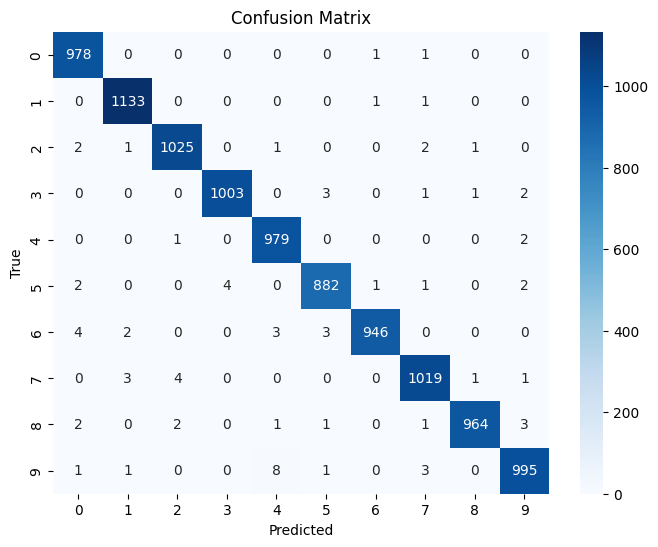

In [164]:
cm = confusion_matrix(all_true_labels, all_predicted_labels)
class_names = [str(i) for i in range(10)]  # Assuming 10 classes

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Model makes quite a few mistakes when it comes to classifing 4 and 9 and, also 3 and 5. This happens because the sketeton or the structure of these numbers are similar which leads to misclassification.

#### Training the model on noisy dataset

In [165]:
noisy_data = scipy.io.loadmat('./mnist-with-awgn.mat')

In [166]:
noisy_x_train = noisy_data['train_x']
noisy_x_test = noisy_data['test_x']
noisy_y_train = noisy_data['train_y'].astype(np.float64)
noisy_y_test = noisy_data['test_y'].astype(np.float64)

In [16]:
class noisyMNIST(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        label = np.argmax(self.labels[index])
        if self.transform:
            image = self.transform(image)
#         print(image.shape)
        return image, label

In [168]:
n_train = noisy_x_train.shape[0]
n_test = noisy_x_test.shape[0]

noisy_x_train_ = noisy_x_train.reshape(n_train, 28, 28)
noisy_x_test_ = noisy_x_test.reshape(n_test, 28, 28)
# noisty_X_train_

In [169]:
transform = transforms.Compose([transforms.ToTensor()])
noisy_train_dataset = noisyMNIST(noisy_x_train_, noisy_y_train, transform)
# noisy_val_dataset = noisyMNIST(noisy_x_val, noisy_y_val, transform)
noisy_test_dataset = noisyMNIST(noisy_x_test_, noisy_y_test, transform)
print(len(noisy_train_dataset))

60000


In [170]:
noisy_val_dataset = Subset(noisy_train_dataset, torch.arange(0, 10000))
noisy_train_dataset = Subset(noisy_train_dataset, torch.arange(10000, len(noisy_train_dataset)))

In [172]:
cnn_model = CNN(noisy_train_dataset, noisy_val_dataset, batch_size=128, kernel_size=7, dropout_rate=0.75, max_epochs=15)
# cnn_model = cnn_model.to('cuda')
cnn_model.fit()
hist = cnn_model.train()

Epoch 1/15: accuracy: 0.8894, loss: 0.3492, val_accuracy: 0.9636, val_loss: 0.1172
Epoch 2/15: accuracy: 0.9636, loss: 0.1179, val_accuracy: 0.9770, val_loss: 0.0761
Epoch 3/15: accuracy: 0.9736, loss: 0.0842, val_accuracy: 0.9771, val_loss: 0.0705
Epoch 4/15: accuracy: 0.9800, loss: 0.0659, val_accuracy: 0.9782, val_loss: 0.0705
Epoch 5/15: accuracy: 0.9833, loss: 0.0537, val_accuracy: 0.9815, val_loss: 0.0633
Epoch 6/15: accuracy: 0.9843, loss: 0.0471, val_accuracy: 0.9812, val_loss: 0.0671
Epoch 7/15: accuracy: 0.9878, loss: 0.0379, val_accuracy: 0.9829, val_loss: 0.0638
Epoch 8/15: accuracy: 0.9893, loss: 0.0320, val_accuracy: 0.9844, val_loss: 0.0613
Epoch 9/15: accuracy: 0.9915, loss: 0.0267, val_accuracy: 0.9847, val_loss: 0.0650
Epoch 10/15: accuracy: 0.9914, loss: 0.0255, val_accuracy: 0.9856, val_loss: 0.0637
Epoch 11/15: accuracy: 0.9930, loss: 0.0218, val_accuracy: 0.9829, val_loss: 0.0751
Epoch 12/15: accuracy: 0.9942, loss: 0.0184, val_accuracy: 0.9836, val_loss: 0.0648
E

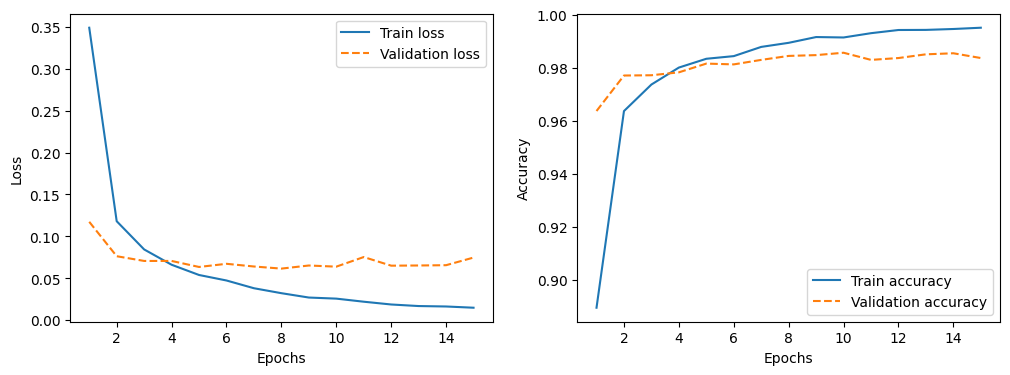

In [173]:
x_axis = np.arange(len(hist[0])) + 1
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_axis, hist[0], linestyle='-', label='Train loss')
ax.plot(x_axis, hist[2], linestyle='--', label='Validation loss')
ax.legend()
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_axis, hist[1], linestyle='-', label = 'Train accuracy')
ax.plot(x_axis, hist[3], linestyle='--', label = 'Validation accuracy')
ax.legend()
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
plt.show()


In [174]:
test_dl = DataLoader(noisy_test_dataset, batch_size=128, shuffle=True)

test_accuracy = 0
all_true_labels = []
all_predicted_labels = []

for x_batch, y_batch in test_dl:
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    y_pred = cnn_model.predict(x_batch)
    test_accuracy += (y_pred == y_batch).sum().item()
    all_true_labels.extend(y_batch.tolist())
    all_predicted_labels.extend(y_pred.tolist())

test_accuracy /= len(test_dl.dataset)

class_names = [str(i) for i in range(10)]  # Assuming 10 classes
print("Test Accuracy:", test_accuracy)
print(classification_report(all_true_labels, all_predicted_labels, target_names=class_names))

/tmp/ipykernel_32/1456230094.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


Test Accuracy: 0.986
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.98      1.00      0.99      1032
           3       0.98      0.99      0.99      1010
           4       0.99      0.98      0.98       982
           5       0.98      0.99      0.99       892
           6       0.99      0.98      0.99       958
           7       0.98      0.98      0.98      1028
           8       0.99      0.98      0.98       974
           9       0.97      0.98      0.97      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



#### Creating a noisy dataset 

In [2]:
def add_noise(img, sigma):
    noise = torch.randn(img.size()) * sigma
    noisy_image = img + noise
    return torch.clamp(noisy_image, 0, 1)

In [7]:
sigma = 0.2
noisy_mnist_train_dataset = [(add_noise(image, sigma), image) for image, label in mnist_train_dataset]
noisy_mnist_train_labels = [label for image, label in mnist_train_dataset]
noisy_mnist_val_dataset = [(add_noise(image, sigma), image) for image, label in mnist_val_dataset]
noisy_mnist_val_labels = [label for image, label in mnist_val_dataset]
noisy_mnist_test_dataset = [(add_noise(image, sigma), image) for image, label in mnist_test_dataset]
noisy_mnist_test_labels = [label for image, label in mnist_test_dataset]

# print(noisy_mnist_test_labels)

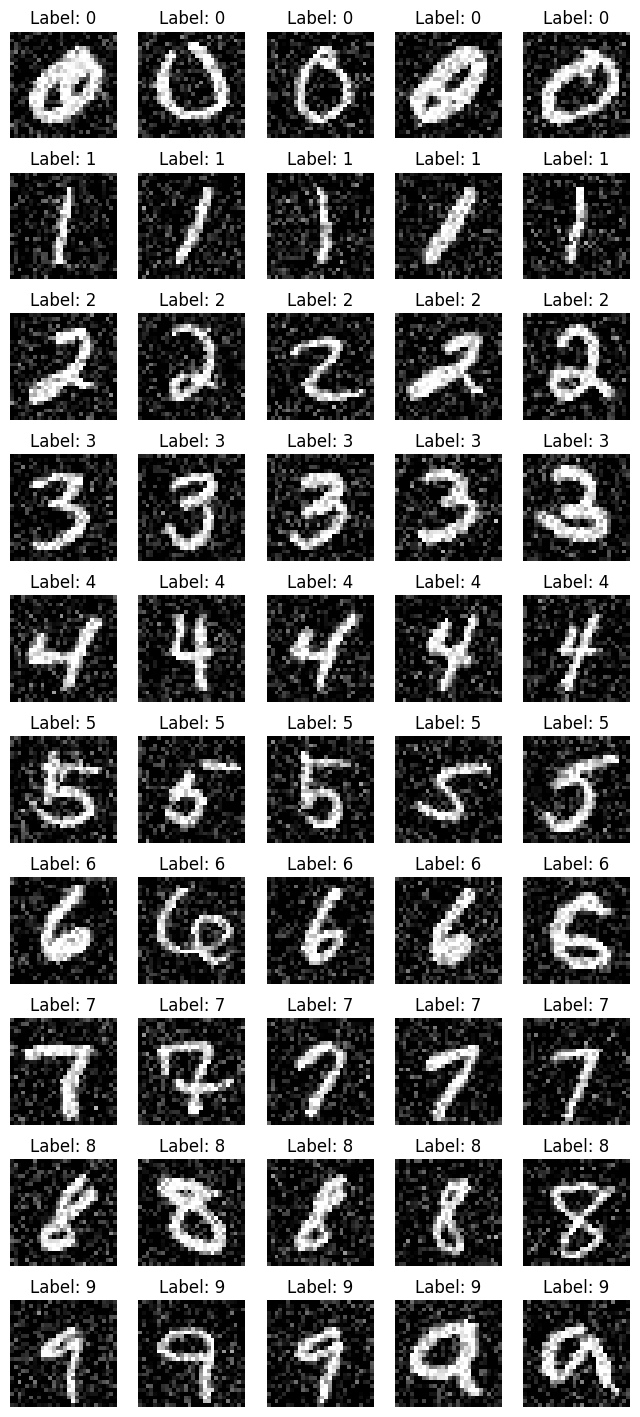

In [55]:
class_samples = {}
num_samples_per_class = 5

for i in range(10):
    class_samples[i] = []

for i in range(len(noisy_mnist_train_dataset)):
    image, _ = noisy_mnist_train_dataset[i]
    label = noisy_mnist_train_labels[i]
    if(len(class_samples[label]) < num_samples_per_class):
        class_samples[label].append(image)

fig, ax = plt.subplots(10, num_samples_per_class, figsize=(8, 18))
for i in range(10):
    for j in range(num_samples_per_class):
        ax[i, j].imshow(class_samples[i][j].squeeze().numpy(), cmap='gray')
        ax[i, j].set_title(f"Label: {i}")
        ax[i, j].axis('off')
plt.show()

#### AutoEncoder

In [56]:
class AutoEncoder(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size=5, stride=1, padding=2):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channel, 8, kernel_size=kernel_size,padding=padding, stride = stride),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(8, 16, kernel_size=kernel_size, padding=padding, stride = stride),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 8, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(8, in_channel, kernel_size=2, stride=2),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [57]:
model = AutoEncoder(in_channel=1, out_channel=8)
model = model.to(device)
model

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(16, 8, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(8, 1, kernel_size=(2, 2), stride=(2, 2))
    (3): Sigmoid()
  )
)

In [58]:
# train_ds = TensorDataset(noisy_x_train, noisy_x_train)
batch_size = 64
torch.manual_seed(42)

print(len(noisy_mnist_test_dataset))

train_dl = DataLoader(noisy_mnist_train_dataset, batch_size, shuffle=False)
test_dl = DataLoader(noisy_mnist_test_dataset, len(noisy_mnist_test_dataset), shuffle=False)
# noisy_x_train[0]

10000


In [59]:
loss_fn = nn.BCELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.05)
torch.manual_seed(42)
max_epochs = 20

train_loss = [0]*max_epochs
# train_accuracy = [0]*max_epochs

for epoch in range(max_epochs):
    for x_batch, y_batch in train_dl:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        x_batch = torch.tensor(x_batch).float()
        y_batch = torch.tensor(y_batch).float()
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimiser.step()
        optimiser.zero_grad()
        train_loss[epoch] += loss.item() * batch_size
    
    train_loss[epoch] /= len(train_dl.dataset)
    print(f"Epoch {epoch}/{max_epochs}: Train loss: {train_loss[epoch]:.4f}")

/tmp/ipykernel_32/4143749241.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_batch = torch.tensor(x_batch).float()
/tmp/ipykernel_32/4143749241.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch).float()


Epoch 0/20: Train loss: 0.1357
Epoch 1/20: Train loss: 0.1056
Epoch 2/20: Train loss: 0.1035
Epoch 3/20: Train loss: 0.1024
Epoch 4/20: Train loss: 0.1015
Epoch 5/20: Train loss: 0.1013
Epoch 6/20: Train loss: 0.1011
Epoch 7/20: Train loss: 0.1009
Epoch 8/20: Train loss: 0.1008
Epoch 9/20: Train loss: 0.1008
Epoch 10/20: Train loss: 0.1004
Epoch 11/20: Train loss: 0.1001
Epoch 12/20: Train loss: 0.0996
Epoch 13/20: Train loss: 0.0993
Epoch 14/20: Train loss: 0.0989
Epoch 15/20: Train loss: 0.0986
Epoch 16/20: Train loss: 0.0976
Epoch 17/20: Train loss: 0.0963
Epoch 18/20: Train loss: 0.0957
Epoch 19/20: Train loss: 0.0954


In [60]:
x_sample = noisy_mnist_test_dataset[0][0]
x_sample = torch.tensor(x_sample, dtype=torch.float32)
x_sample = x_sample.to(device)
pred = model(x_sample)
print(pred.shape)

torch.Size([1, 28, 28])


/tmp/ipykernel_32/529641451.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_sample = torch.tensor(x_sample, dtype=torch.float32)


/tmp/ipykernel_32/1469000471.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


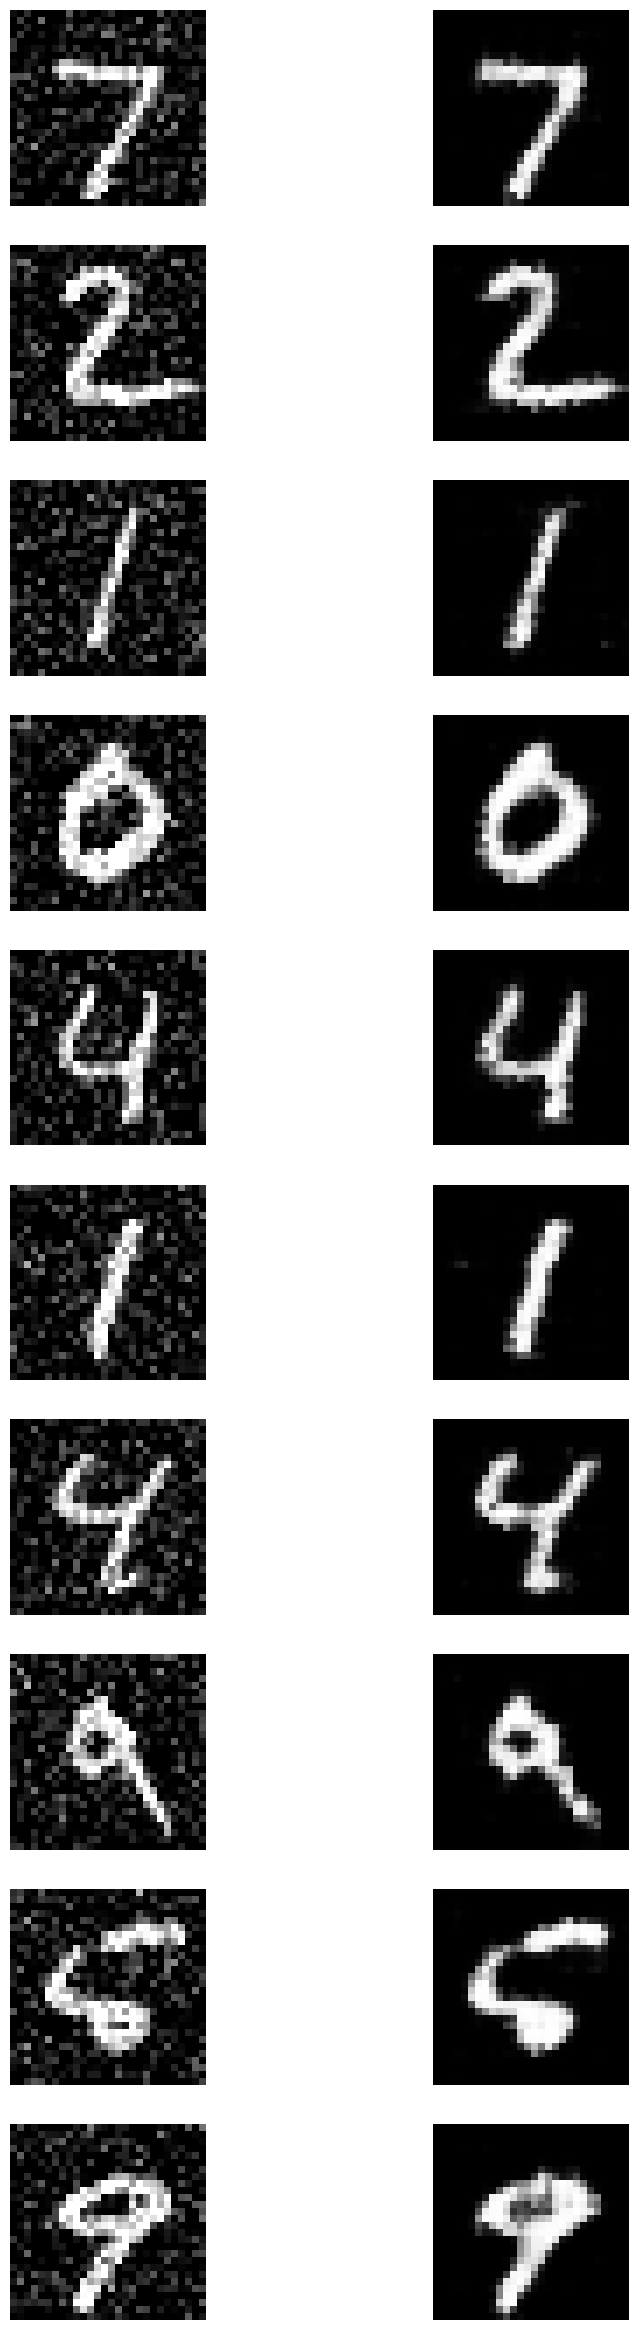

In [61]:
i = 0
plt.figure(figsize=(10, 30))
for x, y in noisy_mnist_test_dataset:
    x = x.to(device)
    y = y.to(device)
    x = torch.tensor(x, dtype=torch.float32)
    pred = model(x)
    pred = pred.cpu().detach().numpy()
    plt.subplot(10, 2, 2*i+1)
    plt.imshow(x[0].cpu().detach().numpy(), cmap='gray')
    plt.axis("off")
    plt.subplot(10, 2, 2*i+2)
    plt.imshow(pred[0], cmap='gray')
    plt.axis("off")
    i += 1
    if i == 10:
        break


In [184]:
denoised_train_images = []

for i in range(len(noisy_mnist_train_labels)):
    x = torch.tensor(noisy_mnist_train_dataset[i][0], dtype=torch.float32)
    x = x.to(device)
    pred = model(x)
    pred = pred.cpu().detach().numpy()[0]
#     print(pred.shape)
    denoised_train_images.append(pred)

/tmp/ipykernel_32/1312673137.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(noisy_mnist_train_dataset[i][0], dtype=torch.float32)


In [185]:
denoised_val_images = []

for i in range(len(noisy_mnist_val_labels)):
    x = torch.tensor(noisy_mnist_val_dataset[i][0], dtype=torch.float32)
    x = x.to(device)
    pred = model(x)
    pred = pred.cpu().detach().numpy()[0]
    denoised_val_images.append(pred)

/tmp/ipykernel_32/3766328130.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(noisy_mnist_val_dataset[i][0], dtype=torch.float32)


In [194]:
denoised_test_images = []

for i in range(len(noisy_mnist_test_labels)):
    x = torch.tensor(noisy_mnist_test_dataset[i][0], dtype=torch.float32)
    x = x.to(device)
    pred = model(x)
    pred = pred.cpu().detach().numpy()[0]
    denoised_test_images.append(pred)

/tmp/ipykernel_32/2885512336.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(noisy_mnist_test_dataset[i][0], dtype=torch.float32)


In [187]:
class noisyMNIST_(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        if self.transform:
            image = self.transform(image)
#         print(image.shape)
        return image, label

In [198]:
transform = transforms.Compose([transforms.ToTensor()])

noisy_train_dataset = noisyMNIST_(denoised_train_images, noisy_mnist_train_labels, transform)
noisy_test_dataset = noisyMNIST_(denoised_test_images, noisy_mnist_test_labels, transform)
noisy_val_dataset = noisyMNIST_(denoised_val_images, noisy_mnist_val_labels, transform)

In [189]:
cnn_model = CNN(noisy_train_dataset, noisy_val_dataset, learning_rate=0.00025, max_epochs = 15, kernel_size=7, dropout_rate=0.75, batch_size=128)
cnn_model.fit()
hist = cnn_model.train()

Epoch 1/15: accuracy: 0.8592, loss: 0.4607, val_accuracy: 0.9565, val_loss: 0.1421
Epoch 2/15: accuracy: 0.9547, loss: 0.1440, val_accuracy: 0.9733, val_loss: 0.0920
Epoch 3/15: accuracy: 0.9679, loss: 0.1057, val_accuracy: 0.9771, val_loss: 0.0770
Epoch 4/15: accuracy: 0.9731, loss: 0.0856, val_accuracy: 0.9789, val_loss: 0.0660
Epoch 5/15: accuracy: 0.9767, loss: 0.0752, val_accuracy: 0.9829, val_loss: 0.0581
Epoch 6/15: accuracy: 0.9793, loss: 0.0653, val_accuracy: 0.9815, val_loss: 0.0606
Epoch 7/15: accuracy: 0.9814, loss: 0.0589, val_accuracy: 0.9834, val_loss: 0.0569
Epoch 8/15: accuracy: 0.9833, loss: 0.0518, val_accuracy: 0.9838, val_loss: 0.0523
Epoch 9/15: accuracy: 0.9849, loss: 0.0476, val_accuracy: 0.9849, val_loss: 0.0481
Epoch 10/15: accuracy: 0.9863, loss: 0.0431, val_accuracy: 0.9853, val_loss: 0.0510
Epoch 11/15: accuracy: 0.9869, loss: 0.0396, val_accuracy: 0.9857, val_loss: 0.0475
Epoch 12/15: accuracy: 0.9884, loss: 0.0360, val_accuracy: 0.9870, val_loss: 0.0443
E

In [199]:
test_dl = DataLoader(noisy_test_dataset, batch_size=128, shuffle=True)

test_accuracy = 0
all_true_labels = []
all_predicted_labels = []

for x_batch, y_batch in test_dl:
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    y_pred = cnn_model.predict(x_batch)
    test_accuracy += (y_pred == y_batch).sum().item()
    all_true_labels.extend(y_batch.tolist())
    all_predicted_labels.extend(y_pred.tolist())

test_accuracy /= len(test_dl.dataset)

class_names = [str(i) for i in range(10)]  # Assuming 10 classes
print("Test Accuracy:", test_accuracy)
print(classification_report(all_true_labels, all_predicted_labels, target_names=class_names))

/tmp/ipykernel_32/1456230094.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


Test Accuracy: 0.9881
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       1.00      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.98      0.99       892
           6       0.99      0.99      0.99       958
           7       0.98      0.99      0.98      1028
           8       0.97      1.00      0.99       974
           9       0.99      0.97      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



#### Denoising the noisy MNIST dataset and training the CNN model

In [62]:
noisy_data = scipy.io.loadmat('./mnist-with-awgn.mat')
# noisy_data

In [63]:
noisy_train_x_ = noisy_data['train_x']
noisy_train_y_ = noisy_data['train_y']
noisy_test_x_ = noisy_data['test_x'].astype(np.float64)
noisy_test_y_ = noisy_data['test_y'].astype(np.float64)

n_train = len(noisy_train_x_)
n_test = len(noisy_test_x_)

noisy_train_x_ = noisy_train_x_.reshape(n_train, 28, 28)
noisy_test_x_ = noisy_test_x_.reshape(n_test, 28, 28)

In [64]:
transform = transforms.Compose([transforms.ToTensor()])
noisy_dataset_ = noisyMNIST(noisy_train_x_, noisy_train_y_, transform)
noisy_dataset_test = noisyMNIST(noisy_test_x_, noisy_test_y_, transform)

noisy_dataset_val = Subset(noisy_dataset_, torch.arange(0, 10000))
noisy_dataset_train = Subset(noisy_dataset_, torch.arange(10000, len(noisy_dataset_)))

In [65]:
denoised_train_images = []

for i in range(len(noisy_dataset_train)):
    x = torch.tensor(noisy_dataset_train[i][0], dtype=torch.float32)
    x = x.to(device)
    pred = model(x)
    pred = pred.cpu().detach().numpy()[0]
#     print(pred.shape)
    denoised_train_images.append(pred)

/tmp/ipykernel_32/2303807640.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(noisy_dataset_train[i][0], dtype=torch.float32)


In [66]:
denoised_val_images = []

for i in range(len(noisy_dataset_val)):
    x = torch.tensor(noisy_dataset_val[i][0], dtype=torch.float32)
    x = x.to(device)
    pred = model(x)
    pred = pred.cpu().detach().numpy()[0]
#     print(pred.shape)
    denoised_val_images.append(pred)

/tmp/ipykernel_32/3564536782.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(noisy_dataset_val[i][0], dtype=torch.float32)


In [67]:
denoised_test_images = []

for i in range(len(noisy_dataset_test)):
    x = torch.tensor(noisy_dataset_test[i][0], dtype=torch.float32)
    x = x.to(device)
    pred = model(x)
    pred = pred.cpu().detach().numpy()[0]
#     print(pred.shape)
    denoised_test_images.append(pred)

/tmp/ipykernel_32/4052878676.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(noisy_dataset_test[i][0], dtype=torch.float32)


In [68]:
cnn_model = CNN(noisy_dataset_train, noisy_dataset_val, learning_rate=0.00025, max_epochs = 15, kernel_size=7, dropout_rate=0.75, batch_size=128)
cnn_model.fit()
hist = cnn_model.train()

Epoch 1/15: accuracy: 0.8185, loss: 0.5870, val_accuracy: 0.9458, val_loss: 0.1876
Epoch 2/15: accuracy: 0.9466, loss: 0.1769, val_accuracy: 0.9621, val_loss: 0.1247
Epoch 3/15: accuracy: 0.9615, loss: 0.1266, val_accuracy: 0.9688, val_loss: 0.0987
Epoch 4/15: accuracy: 0.9673, loss: 0.1032, val_accuracy: 0.9744, val_loss: 0.0862
Epoch 5/15: accuracy: 0.9729, loss: 0.0872, val_accuracy: 0.9768, val_loss: 0.0758
Epoch 6/15: accuracy: 0.9763, loss: 0.0760, val_accuracy: 0.9781, val_loss: 0.0720
Epoch 7/15: accuracy: 0.9791, loss: 0.0655, val_accuracy: 0.9786, val_loss: 0.0692
Epoch 8/15: accuracy: 0.9817, loss: 0.0582, val_accuracy: 0.9801, val_loss: 0.0660
Epoch 9/15: accuracy: 0.9829, loss: 0.0530, val_accuracy: 0.9808, val_loss: 0.0640
Epoch 10/15: accuracy: 0.9844, loss: 0.0485, val_accuracy: 0.9796, val_loss: 0.0680
Epoch 11/15: accuracy: 0.9863, loss: 0.0410, val_accuracy: 0.9811, val_loss: 0.0659
Epoch 12/15: accuracy: 0.9882, loss: 0.0366, val_accuracy: 0.9822, val_loss: 0.0640
E

In [69]:
# performance of the CNN on denoised dataset 

test_dl = DataLoader(noisy_dataset_test, batch_size=128, shuffle=True)

test_accuracy = 0
all_true_labels = []
all_predicted_labels = []

for x_batch, y_batch in test_dl:
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    y_pred = cnn_model.predict(x_batch)
    test_accuracy += (y_pred == y_batch).sum().item()
    all_true_labels.extend(y_batch.tolist())
    all_predicted_labels.extend(y_pred.tolist())

test_accuracy /= len(test_dl.dataset)

class_names = [str(i) for i in range(10)]  # Assuming 10 classes
print("Test Accuracy:", test_accuracy)
print(classification_report(all_true_labels, all_predicted_labels, target_names=class_names))

/tmp/ipykernel_32/1456230094.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


Test Accuracy: 0.9844
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.98      0.99      1032
           3       0.98      0.99      0.98      1010
           4       0.99      0.98      0.99       982
           5       0.98      0.98      0.98       892
           6       0.99      0.98      0.99       958
           7       0.98      0.98      0.98      1028
           8       0.97      0.99      0.98       974
           9       0.98      0.97      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



The CNN model trained on the original MNIST dataset performs the best giving a accuracy 99%. The model train by denoising the noisy image dataset provide also performs well giving an accuracy of 98% on test dataset. This indicates that the autoencoder does a good job denoising the images. The model trained on noisy image dataset gives an accuracy of 98%, but it could perform if the images where high dimensional

# Double MNIST dataset

In [63]:
dir_name_train = './double_mnist_seed_123_image_size_64_64/train'
dir_name_val = './double_mnist_seed_123_image_size_64_64/val'
dir_name_test = './double_mnist_seed_123_image_size_64_64/test'

In [64]:
x_train = []
y_train = []
x_test = []
y_test = []
x_val = []
y_val = []

for folder_name in os.listdir(dir_name_train):
    folder_path = os.path.join(dir_name_train, folder_name)
    if os.path.isdir(folder_path):
        # print(folder_name)
        label = [int(digit) for digit in folder_name]
        if(label[0]==label[1]):
            continue
        label = sorted(label)
        
        for image_file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_file)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            x_train.append(image)
            y_train.append(label)

for folder_name in os.listdir(dir_name_val):
    folder_path = os.path.join(dir_name_val, folder_name)
    if os.path.isdir(folder_path):
        # print(folder_name)
        label = [int(digit) for digit in folder_name]
        if(label[0]==label[1]):
            continue
        label = sorted(label)
        
        for image_file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_file)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            x_val.append(image)
            y_val.append(label)

for folder_name in os.listdir(dir_name_test):
    folder_path = os.path.join(dir_name_test, folder_name)
    if os.path.isdir(folder_path):
        # print(folder_name)
        label = [int(digit) for digit in folder_name]
        if(label[0]==label[1]):
            continue
        label = sorted(label)
        
        for image_file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_file)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            x_test.append(image)
            y_test.append(label)

In [65]:
len(x_test)

18000

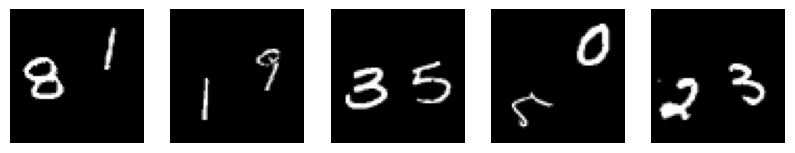

In [73]:
plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(x_train[i*1000], cmap='gray')
    plt.axis("off")

In [66]:
y_train = np.array(y_train)
num_classes = 10
y_onehot_train = np.zeros((y_train.shape[0], num_classes))
for i in range(y_train.shape[0]):
    y_onehot_train[i, y_train[i]] = 1

y_test = np.array(y_test)
y_onehot_test = np.zeros((y_test.shape[0], num_classes))
for i in range(y_test.shape[0]):
    y_onehot_test[i, y_test[i]] = 1

y_val = np.array(y_val)
y_onehot_val = np.zeros((y_val.shape[0], num_classes))
for i in range(y_val.shape[0]):
    y_onehot_val[i, y_val[i]] = 1

In [27]:
y_onehot_train[10000]

array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.])

In [28]:
class DoubleMNIST(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        if self.transform:
            image = self.transform(image)
        return image, label

In [137]:
class CNNMultiLabel(nn.Module):
    def __init__(self, train, val, batch_size=32, learning_rate = 0.1, kernel_size = 5, strides = 1, max_epochs = 10, dropout_rate = 0.5, num_classes = 10, input_channels = 1, verbose= True, image_size = 64):
        super(CNNMultiLabel, self).__init__()
        self.batch_size = batch_size
        self.train_dl = DataLoader(train, batch_size=self.batch_size, shuffle=True)
        self.val_dl = DataLoader(val, batch_size=self.batch_size, shuffle=True)
        self.learning_rate = learning_rate
        self.kernel_size = kernel_size
        self.strides = strides
        self.max_epochs = max_epochs
        self.dropout_rate = dropout_rate
        self.input_channels = input_channels
        self.num_classes = num_classes
        self.verbose = verbose
        self.image_size = image_size

    def _get_features_size(self, input_channels):
        with torch.no_grad():
            x = torch.zeros(1, input_channels, self.image_size, self.image_size)
            x = self.model[:6](x)
            return x.view(x.size(0), -1).shape[1]

    def fit(self):
        self.model = nn.Sequential()
        self.model.add_module('conv1', nn.Conv2d(in_channels=self.input_channels, out_channels=32, kernel_size=self.kernel_size, stride=self.strides, padding=2))
        self.model.add_module('relu1', nn.ReLU())
        self.model.add_module('pool1', nn.MaxPool2d(kernel_size=2))
        self.model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=self.kernel_size, stride=self.strides, padding=2))
        self.model.add_module('relu2', nn.ReLU())
        self.model.add_module('pool2', nn.MaxPool2d(kernel_size=2))
        self.model.add_module('flatten', nn.Flatten())

        self.feature_size = self._get_features_size(self.input_channels)

        self.model.add_module('fc1', nn.Linear(self.feature_size, 1024))
        self.model.add_module('relu3', nn.ReLU())
        self.model.add_module('dropout', nn.Dropout(self.dropout_rate))
        self.model.add_module('fc2', nn.Linear(1024, self.num_classes))

        self.loss_fn = nn.BCEWithLogitsLoss()
        self.optimiser = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)


    def train(self):
        train_accuracy = [0] * self.max_epochs
        train_loss = [0] * self.max_epochs
        val_accuracy = [0] * self.max_epochs
        val_loss = [0] * self.max_epochs
        self.model = self.model.to(device)
        for epoch in range(self.max_epochs):
#             self.model.train()
            for x_batch, y_batch in self.train_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                y_pred = self.model(x_batch)
                loss = self.loss_fn(y_pred, y_batch.float())
                loss.backward()
                self.optimiser.step()
                self.optimiser.zero_grad()

                train_loss[epoch] += loss.item()*y_batch.size(0)
                top_values, top_indices = torch.topk(y_pred, k=2, dim=1)
                top_indices = np.sort(top_indices.cpu().numpy(), axis=1)
                y_true = [np.where(row==1)[0] for row in y_batch.cpu().numpy()]
                train_accuracy[epoch] += np.sum(top_indices == y_true)/2

            train_loss[epoch] /= len(self.train_dl.dataset)
            train_accuracy[epoch] /= len(self.train_dl.dataset)

            self.model.eval()

            with torch.no_grad():
                for x_batch, y_batch in self.val_dl:
                    x_batch = x_batch.to(device)
                    y_batch = y_batch.to(device)
                    y_pred = self.model(x_batch)
                    loss = self.loss_fn(y_pred, y_batch)
                    val_loss[epoch] += loss.item()*y_batch.size(0)
                    top_values, top_indices = torch.topk(y_pred, k=2, dim=1)
                    top_indices = np.sort(top_indices.cpu().numpy(), axis=1)
                    y_true = [np.where(row==1)[0] for row in y_batch.cpu().numpy()]
                    val_accuracy[epoch] += np.sum(top_indices == y_true)/2
                
                val_loss[epoch] /= len(self.val_dl.dataset)
                val_accuracy[epoch] /= len(self.val_dl.dataset)
            
            if(self.verbose):
                print(f'Epoch {epoch+1}/{self.max_epochs}: accuracy: {train_accuracy[epoch]:.4f}, loss: {train_loss[epoch]:.4f}, val_accuracy: {val_accuracy[epoch]:.4f}, val_loss: {val_loss[epoch]:.4f}')

        return train_loss, train_accuracy, val_loss, val_accuracy
    
    def get_model(self):
        return self.model

In [30]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = DoubleMNIST(x_train, y_onehot_train, transform)
val_dataset = DoubleMNIST(x_val, y_onehot_val, transform)
test_dataset = DoubleMNIST(x_test, y_onehot_test, transform)

In [16]:
cnn_mmodel = CNNMultiLabel(train_dataset, val_dataset, batch_size=64, max_epochs=10, learning_rate=0.0001)
# model = model.to(device)
cnn_mmodel.fit()
hist = cnn_mmodel.train()

Epoch 1/10: accuracy: 0.4918, loss: 0.3557, val_accuracy: 0.5030, val_loss: 0.3378
Epoch 2/10: accuracy: 0.8267, loss: 0.1533, val_accuracy: 0.6430, val_loss: 0.2701
Epoch 3/10: accuracy: 0.9162, loss: 0.0875, val_accuracy: 0.6948, val_loss: 0.2491
Epoch 4/10: accuracy: 0.9463, loss: 0.0603, val_accuracy: 0.7519, val_loss: 0.2216
Epoch 5/10: accuracy: 0.9625, loss: 0.0448, val_accuracy: 0.7698, val_loss: 0.2231
Epoch 6/10: accuracy: 0.9744, loss: 0.0339, val_accuracy: 0.7520, val_loss: 0.2414
Epoch 7/10: accuracy: 0.9825, loss: 0.0257, val_accuracy: 0.7814, val_loss: 0.2308
Epoch 8/10: accuracy: 0.9886, loss: 0.0190, val_accuracy: 0.7630, val_loss: 0.2545
Epoch 9/10: accuracy: 0.9934, loss: 0.0140, val_accuracy: 0.7704, val_loss: 0.2668
Epoch 10/10: accuracy: 0.9960, loss: 0.0101, val_accuracy: 0.7665, val_loss: 0.2869


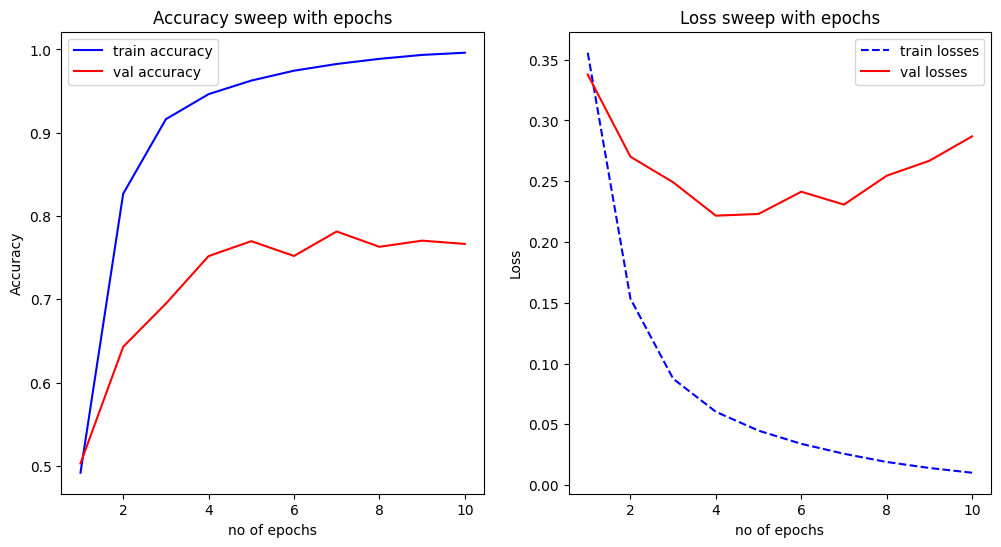

In [17]:
train_loss, train_accuracy, val_loss, val_accuracy = hist
v_epochs = range(1, len(val_accuracy)+1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(v_epochs, train_accuracy, color= 'blue', linestyle='-', label='train accuracy')
plt.plot(v_epochs, val_accuracy, color= 'red', linestyle='-', label='val accuracy')
plt.xlabel('no of epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy sweep with epochs')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(v_epochs, train_loss, color='blue', linestyle='--', label='train losses')
plt.plot(v_epochs, val_loss, color='red', linestyle='-', label='val losses')
plt.xlabel('no of epochs')
plt.ylabel('Loss')
plt.title('Loss sweep with epochs')
plt.legend()

In [12]:
sweep_configuration = {
    "method": "random",
    "name": "sweep",
    "metric": {"goal": "maximize", "name": "accuracy"},
    "parameters": {
        "batch_size": {"values": [32, 64, 128, 256, 512, 1024]},
        "dropout_rate": {"values": [0.25, 0.5, 0.75]},
        "kernel_size": {"values": [1, 3, 5]}
    },
}

sweep_id = wandb.sweep(sweep=sweep_configuration, project="5.1-CNN-classification")

def tuning():
    run = wandb.init()
    batch_size = wandb.config.batch_size
    dropout_rate = wandb.config.dropout_rate
    kernel_size = wandb.config.kernel_size

    # for epoch in np.arange(epochs-10, epochs):
    model = CNNMultiLabel(train_dataset, val_dataset, batch_size=batch_size, max_epochs=15, learning_rate=0.0001, kernel_size=kernel_size, dropout_rate=dropout_rate, verbose=False)
    model.fit()
    hist = model.train()
    # accuracies, losses, v_epochs = regression_model.get_metric_for_each_epoch()
    accuracies = hist[3]
    losses = hist[2]
    v_epochs = range(1, 15+1)
    for accuracy, loss, epoch_count in zip(accuracies, losses, v_epochs):
        wandb.log({"accuracy": accuracy, "loss": loss})

wandb.agent(sweep_id, function=tuning, count=20)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: ead2trjc
Sweep URL: https://wandb.ai/anushka-agrawal/5.1-CNN-classification/sweeps/ead2trjc


wandb: Agent Starting Run: nyoh81m4 with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.25
wandb: 	kernel_size: 5
wandb: Currently logged in as: anushka-agrawal. Use `wandb login --relogin` to force relogin


accuracy,▁▃▄▅▅▆▆▇▇▇▇████
loss,█▆▅▄▃▃▂▂▂▂▁▁▁▁▁
accuracy,0.73004
loss,0.23025


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: c71al1wm with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.25
wandb: 	kernel_size: 3


accuracy,▁▃▅▆▇▇▇████████
loss,▆▄▂▁▁▁▂▂▃▄▅▅▆██
accuracy,0.77139
loss,0.37774


wandb: Agent Starting Run: upf4ulot with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.25
wandb: 	kernel_size: 1


accuracy,▁▃▄▄▅▆▆▆▆▇▇█▇█▇
loss,█▅▅▃▄▃▄▃▄▂▃▁▃▁▂
accuracy,0.28979
loss,0.46965


wandb: Agent Starting Run: dcjgjpqr with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.75
wandb: 	kernel_size: 1


accuracy,▁▂▃▃▃▄▄▄▅▅▆▆▆▇█
loss,█▇▇▇▇▆▆▆▅▄▄▃▃▂▁
accuracy,0.41582
loss,0.40677


wandb: Agent Starting Run: h5kepiln with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.5
wandb: 	kernel_size: 3


accuracy,▁▄▆▆▇▇▇▇█▇█████
loss,▅▃▂▁▁▁▁▂▃▄▅▆▇██
accuracy,0.75507
loss,0.41372


wandb: Agent Starting Run: dawhrjow with config:
wandb: 	batch_size: 1024
wandb: 	dropout_rate: 0.5
wandb: 	kernel_size: 3


accuracy,▁▃▄▄▅▆▆▆▆▇▇▇▇██
loss,█▇▆▅▄▄▃▃▃▂▂▂▂▁▁
accuracy,0.53636
loss,0.32637


wandb: Agent Starting Run: po9nbb8l with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.5
wandb: 	kernel_size: 3


accuracy,▁▄▆▆▇▇▇████████
loss,▆▄▂▂▁▁▃▂▃▄▅▆▇▇█
accuracy,0.76207
loss,0.39628


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mm81z3ev with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.75
wandb: 	kernel_size: 3


accuracy,▁▃▄▅▆▆▇▇▇▇█████
loss,█▆▅▄▃▃▂▂▂▁▁▁▁▁▁
accuracy,0.71814
loss,0.2517


wandb: Agent Starting Run: yvl6gu94 with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.25
wandb: 	kernel_size: 1


accuracy,▁▁▃▄▃▄▅▄▅▆▆▇▇▇█
loss,█▆▅▄▅▅▄▄▆▂▄▂▁▂▁
accuracy,0.32404
loss,0.45849


wandb: Agent Starting Run: 7kbymb8p with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.75
wandb: 	kernel_size: 1


accuracy,▁▃▄▅▆▆▆▆▆▆▇▇▇██
loss,█▅▅▃▄▂▅▃▅▃▃▂▃▂▁
accuracy,0.31046
loss,0.45982


wandb: Agent Starting Run: i4k7qo6l with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.25
wandb: 	kernel_size: 5


accuracy,▁▃▅▅▆▆▇▇▇▇▇███▇
loss,█▆▄▃▂▂▂▁▁▂▂▁▁▁▂
accuracy,0.72107
loss,0.26358


wandb: Agent Starting Run: r2vahf6v with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.75
wandb: 	kernel_size: 5


accuracy,▁▆▆▆▇▇█████████
loss,▃▁▁▁▂▂▂▄▅▄▅▇▆▇█
accuracy,0.76868
loss,0.44252


wandb: Agent Starting Run: u2vpx4ou with config:
wandb: 	batch_size: 1024
wandb: 	dropout_rate: 0.75
wandb: 	kernel_size: 5


accuracy,▁▂▃▄▄▅▅▆▆▇▇▇█▇█
loss,█▇▆▅▄▄▃▃▃▂▂▂▁▁▁
accuracy,0.63132
loss,0.26934


wandb: Agent Starting Run: y8y4elvn with config:
wandb: 	batch_size: 1024
wandb: 	dropout_rate: 0.5
wandb: 	kernel_size: 1


accuracy,▁▄▅▆▆▇▇▇▇▇▇▇███
loss,█▅▃▃▂▂▁▁▃▂▂▂▁▁▁
accuracy,0.28957
loss,0.47038


wandb: Agent Starting Run: hi85yom9 with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.75
wandb: 	kernel_size: 3


accuracy,▁▂▃▄▅▅▆▆▆▇▇▇███
loss,█▇▅▅▄▃▃▃▂▂▂▁▁▁▁
accuracy,0.64871
loss,0.27546


wandb: Agent Starting Run: x7tikimx with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.75
wandb: 	kernel_size: 3


accuracy,▁▄▅▆▇▇▇▇▇▇█▇███
loss,█▄▂▂▁▁▁▁▂▂▂▃▄▄▄
accuracy,0.76875
loss,0.31928


wandb: Agent Starting Run: h4ay17lg with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.5
wandb: 	kernel_size: 3


accuracy,▁▃▄▄▅▆▆▇▇▇█▇███
loss,█▆▅▄▃▃▃▂▂▂▁▁▁▁▁
accuracy,0.71204
loss,0.25078


wandb: Agent Starting Run: vhu940xf with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.25
wandb: 	kernel_size: 5


accuracy,▁▃▅▆▇▇▇▇▇██████
loss,█▅▄▂▂▁▁▁▁▁▁▁▁▂▃
accuracy,0.77493
loss,0.26471


wandb: Agent Starting Run: j7d2esmy with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.5
wandb: 	kernel_size: 1


accuracy,▁▂▂▂▃▃▄▄▅▅▆▇▇██
loss,███▇█▆▆▅▅▄▃▃▂▁▁
accuracy,0.44093
loss,0.39673


wandb: Agent Starting Run: kqf7u3n9 with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.25
wandb: 	kernel_size: 1


accuracy,▁▃▅▅▅▆▅▆▆▆▇▇▇▇█
loss,█▆▅▅▅▄▅▄▃▄▃▄▃▃▁
accuracy,0.31707
loss,0.45593


The link to my wandb report for logging loss and accuracies:
https://api.wandb.ai/links/anushka-agrawal/zcpxpdso

In [31]:
cnn_mmodel = CNNMultiLabel(train_dataset, val_dataset, batch_size=128, kernel_size=5, dropout_rate = 0.25, max_epochs=10, learning_rate=0.0001)
# model = model.to(device)
cnn_mmodel.fit()
hist = cnn_mmodel.train()

Epoch 1/10: accuracy: 0.4399, loss: 0.3884, val_accuracy: 0.4647, val_loss: 0.3584
Epoch 2/10: accuracy: 0.7312, loss: 0.2170, val_accuracy: 0.5887, val_loss: 0.2902
Epoch 3/10: accuracy: 0.8505, loss: 0.1389, val_accuracy: 0.6426, val_loss: 0.2737
Epoch 4/10: accuracy: 0.9025, loss: 0.1002, val_accuracy: 0.6629, val_loss: 0.2623
Epoch 5/10: accuracy: 0.9289, loss: 0.0772, val_accuracy: 0.7009, val_loss: 0.2434
Epoch 6/10: accuracy: 0.9457, loss: 0.0620, val_accuracy: 0.7177, val_loss: 0.2383
Epoch 7/10: accuracy: 0.9580, loss: 0.0511, val_accuracy: 0.7323, val_loss: 0.2409
Epoch 8/10: accuracy: 0.9670, loss: 0.0423, val_accuracy: 0.7172, val_loss: 0.2548
Epoch 9/10: accuracy: 0.9736, loss: 0.0354, val_accuracy: 0.7472, val_loss: 0.2419
Epoch 10/10: accuracy: 0.9807, loss: 0.0293, val_accuracy: 0.7451, val_loss: 0.2567


In [32]:
len(test_dataset)

18000

In [36]:
test_dl = DataLoader(test_dataset, batch_size=128, shuffle=True)

test_accuracy = 0
all_true_labels = []
all_predicted_labels = []

for x_batch, y_batch in test_dl:
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    y_pred = cnn_mmodel.model(x_batch)
#     test_accuracy += (y_pred == y_batch).sum().item()
    
    top_values, top_indices = torch.topk(y_pred, k=2, dim=1)
    top_indices = np.sort(top_indices.cpu().numpy(), axis=1)
    y_true = [np.where(row==1)[0] for row in y_batch.cpu().numpy()]
    test_accuracy += np.sum(top_indices == y_true)/2
 
    all_true_labels.extend(y_batch.tolist())

    all_predicted_labels.extend(y_pred.tolist())

test_accuracy /= len(test_dl.dataset)

class_names = [str(i) for i in range(10)]  # Assuming 10 classes
print("Test Accuracy:", test_accuracy)
# print(classification_report(all_true_labels, all_predicted_labels, target_names=class_names))

Test Accuracy: 0.7348611111111111


In [76]:
class MLPMultiLabel(nn.Module):
    def __init__(self, train, val=None, batch_size=32, learning_rate = 0.001, max_epochs = 10, num_classes = 10, hidden_layer=1, hidden_layer_neurons=13, verbose= True, image_size=64):
        super(MLPMultiLabel, self).__init__()
        self.batch_size = batch_size
        self.train_dl = DataLoader(train, batch_size=self.batch_size, shuffle=True)
        self.val_dl = DataLoader(val, batch_size=self.batch_size, shuffle=False)
        self.hidden_layer = hidden_layer
        self.hidden_layer_neurons = hidden_layer_neurons
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.num_classes = num_classes
        self.verbose = verbose
        self.image_size = image_size

    def _get_features_size(self, input_channels):
        # A helper function to compute the number of features after the convolutional layers
        with torch.no_grad():
            x = torch.zeros(1, input_channels, self.image_size, self.image_size)
            x = self.model[:6](x)
            return x.view(x.size(0), -1).shape[1]

    def fit(self):
        self.model = nn.Sequential()
        self.model.add_module('flatten', nn.Flatten())
        self.model.add_module('fc1', nn.Linear(self.image_size*self.image_size, self.hidden_layer_neurons))
        for i in range(self.hidden_layer-1):
            self.model.add_module(f'relu{i+1}', nn.ReLU())
            self.model.add_module(f'fc{i+2}', nn.Linear(self.hidden_layer_neurons, self.hidden_layer_neurons))
        self.model.add_module(f'relu{self.hidden_layer}', nn.ReLU())
        self.model.add_module(f'fc{self.hidden_layer+1}', nn.Linear(self.hidden_layer_neurons, self.num_classes))

        self.loss_fn = nn.BCEWithLogitsLoss()
        self.optimiser = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)


    def train(self):
        train_accuracy = [0] * self.max_epochs
        train_loss = [0] * self.max_epochs
        val_accuracy = [0] * self.max_epochs
        val_loss = [0] * self.max_epochs

        for epoch in range(self.max_epochs):
            self.model.train()
            for x_batch, y_batch in self.train_dl:
                x_batch = x_batch.view(x_batch.shape[0], -1)
                y_pred = self.model(x_batch)
                loss = self.loss_fn(y_pred, y_batch.float())
                loss.backward()
                self.optimiser.step()
                self.optimiser.zero_grad()

                train_loss[epoch] += loss.item()*y_batch.size(0)
                top_values, top_indices = torch.topk(y_pred, k=2, dim=1)
                top_indices = np.sort(top_indices.numpy(), axis=1)
                y_true = [np.where(row==1)[0] for row in y_batch.numpy()]
                train_accuracy[epoch] += np.sum(top_indices == y_true)/2

            train_loss[epoch] /= len(self.train_dl.dataset)
            train_accuracy[epoch] /= len(self.train_dl.dataset)

            self.model.eval()

            with torch.no_grad():
                for x_batch, y_batch in self.val_dl:
                    y_pred = self.model(x_batch)
                    loss = self.loss_fn(y_pred, y_batch)
                    val_loss[epoch] += loss.item()*y_batch.size(0)
                    top_values, top_indices = torch.topk(y_pred, k=2, dim=1)
                    top_indices = np.sort(top_indices.numpy(), axis=1)
                    y_true = [np.where(row==1)[0] for row in y_batch.numpy()]
                    val_accuracy[epoch] += np.sum(top_indices == y_true)/2
                
                val_loss[epoch] /= len(self.val_dl.dataset)
                val_accuracy[epoch] /= len(self.val_dl.dataset)

            if(self.verbose):
                print(f'Epoch {epoch+1}/{self.max_epochs}: accuracy: {train_accuracy[epoch]:.4f}, loss: {train_loss[epoch]:.4f}, val_accuracy: {val_accuracy[epoch]:.4f}, val_loss: {val_loss[epoch]:.4f}')

        return train_loss, train_accuracy, val_loss, val_accuracy
    
    def get_model(self):
        return self.model
                

In [77]:
model = MLPMultiLabel(train_dataset, val_dataset, batch_size=1000, max_epochs=30, learning_rate=0.001)
model.fit()
train_loss, train_accuracy, val_loss, val_accuracy = model.train()

Epoch 1/30: accuracy: 0.2094, loss: 0.5302, val_accuracy: 0.2364, val_loss: 0.4972
Epoch 2/30: accuracy: 0.3026, loss: 0.4694, val_accuracy: 0.2593, val_loss: 0.4858
Epoch 3/30: accuracy: 0.3196, loss: 0.4564, val_accuracy: 0.2648, val_loss: 0.4836
Epoch 4/30: accuracy: 0.3274, loss: 0.4490, val_accuracy: 0.2639, val_loss: 0.4823
Epoch 5/30: accuracy: 0.3366, loss: 0.4434, val_accuracy: 0.2687, val_loss: 0.4816
Epoch 6/30: accuracy: 0.3438, loss: 0.4393, val_accuracy: 0.2660, val_loss: 0.4832
Epoch 7/30: accuracy: 0.3493, loss: 0.4363, val_accuracy: 0.2730, val_loss: 0.4831
Epoch 8/30: accuracy: 0.3507, loss: 0.4340, val_accuracy: 0.2682, val_loss: 0.4850
Epoch 9/30: accuracy: 0.3540, loss: 0.4322, val_accuracy: 0.2698, val_loss: 0.4837
Epoch 10/30: accuracy: 0.3552, loss: 0.4307, val_accuracy: 0.2709, val_loss: 0.4843
Epoch 11/30: accuracy: 0.3573, loss: 0.4294, val_accuracy: 0.2722, val_loss: 0.4845
Epoch 12/30: accuracy: 0.3594, loss: 0.4282, val_accuracy: 0.2710, val_loss: 0.4844
E

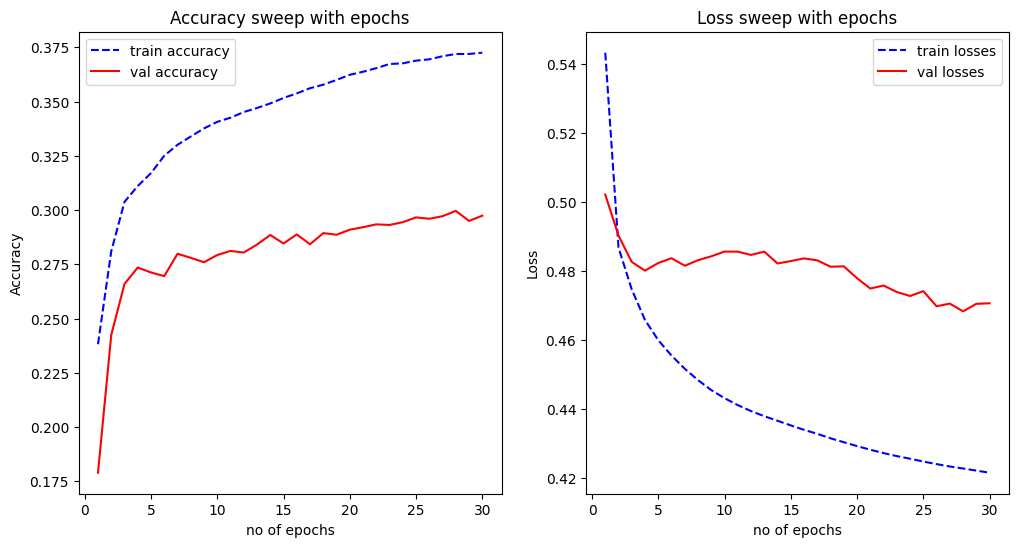

In [22]:
v_epochs = range(1, len(val_accuracy)+1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(v_epochs, train_accuracy, color= 'blue', linestyle='--', label='train accuracy')
plt.plot(v_epochs, val_accuracy, color= 'red', linestyle='-', label='val accuracy')
plt.xlabel('no of epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy sweep with epochs')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(v_epochs, train_loss, color='blue', linestyle='--', label='train losses')
plt.plot(v_epochs, val_loss, color='red', linestyle='-', label='val losses')
plt.xlabel('no of epochs')
plt.ylabel('Loss')
plt.title('Loss sweep with epochs')
plt.legend()

In [13]:
sweep_configuration = {
    "method": "random",
    "name": "sweep",
    "metric": {"goal": "maximize", "name": "accuracy"},
    "parameters": {
        "batch_size": {"values": [32, 64, 128, 256, 512, 1024]},
        "hidden_layer": {"values": [1, 2, 3, 4]},
        "hidden_layer_neurons": {"values": [40, 50, 60, 70, 80]}
    },
}

sweep_id = wandb.sweep(sweep=sweep_configuration, project="5.1-MLP-classification")

def tuning():
    run = wandb.init()
    batch_size = wandb.config.batch_size
    hidden_layer = wandb.config.hidden_layer
    hidden_layer_neurons = wandb.config.hidden_layer_neurons

    # for epoch in np.arange(epochs-10, epochs):
    model = MLPMultiLabel(train_dataset, val_dataset, batch_size=batch_size, learning_rate = 0.0001, max_epochs = 30, hidden_layer=hidden_layer, hidden_layer_neurons=hidden_layer_neurons, verbose= False)

    model.fit()
    hist = model.train()
    # accuracies, losses, v_epochs = regression_model.get_metric_for_each_epoch()
    accuracies = hist[3]
    losses = hist[2]
    v_epochs = range(1, 30+1)
    for accuracy, loss, epoch_count in zip(accuracies, losses, v_epochs):
        wandb.log({"accuracy": accuracy, "loss": loss})

wandb.agent(sweep_id, function=tuning, count=30)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: pewefr0q
Sweep URL: https://wandb.ai/anushka-agrawal/5.1-MLP-classification/sweeps/pewefr0q


wandb: Agent Starting Run: d7seaewv with config:
wandb: 	batch_size: 64
wandb: 	hidden_layer: 4
wandb: 	hidden_layer_neurons: 60
wandb: Currently logged in as: anushka-agrawal. Use `wandb login --relogin` to force relogin


accuracy,▁▂▃▄▄▄▄▄▅▅▆▅▆▆▆▇▇▇▇▇▇▇████▇██▇
loss,█▆▂▁▁▁▁▂▂▃▂▃▃▃▄▄▅▄▅▅▅▆▅▅▅▆▆▆▇█
accuracy,0.35511
loss,0.49228


wandb: Agent Starting Run: htv56fui with config:
wandb: 	batch_size: 128
wandb: 	hidden_layer: 3
wandb: 	hidden_layer_neurons: 80


accuracy,▁▂▂▃▃▄▅▅▅▅▆▆▆▆▇▆▇▇▇▇▇▇▇███████
loss,█▆▅▄▃▂▂▂▂▂▂▁▂▂▂▂▁▂▂▂▂▂▂▁▂▂▃▂▃▃
accuracy,0.39875
loss,0.45749


wandb: Agent Starting Run: n6x0ek6y with config:
wandb: 	batch_size: 64
wandb: 	hidden_layer: 1
wandb: 	hidden_layer_neurons: 40


accuracy,▁▂▃▃▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇████
loss,█▇▆▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▂
accuracy,0.37911
loss,0.44972


wandb: Agent Starting Run: fmc4kr13 with config:
wandb: 	batch_size: 64
wandb: 	hidden_layer: 2
wandb: 	hidden_layer_neurons: 60


accuracy,▁▂▂▃▄▅▅▅▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇█▇█▇███
loss,█▇▆▅▃▃▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▂▂▂▂
accuracy,0.42075
loss,0.42899


wandb: Agent Starting Run: 8xhpa4o6 with config:
wandb: 	batch_size: 1024
wandb: 	hidden_layer: 2
wandb: 	hidden_layer_neurons: 40


accuracy,▃▄▃▁▂▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇███
loss,█▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
accuracy,0.31121
loss,0.47121


wandb: Agent Starting Run: t4gsde9x with config:
wandb: 	batch_size: 128
wandb: 	hidden_layer: 3
wandb: 	hidden_layer_neurons: 50


accuracy,▁▃▄▄▄▅▅▅▆▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇███
loss,█▆▄▂▂▁▂▁▁▁▁▁▂▁▂▃▂▂▃▃▃▃▃▄▄▄▄▄▄▄
accuracy,0.34307
loss,0.47412


wandb: Agent Starting Run: 0k394zaj with config:
wandb: 	batch_size: 1024
wandb: 	hidden_layer: 1
wandb: 	hidden_layer_neurons: 40


accuracy,▁▃▄▅▅▅▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇████
loss,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
accuracy,0.31561
loss,0.46656


wandb: Agent Starting Run: 2dk8l3wv with config:
wandb: 	batch_size: 1024
wandb: 	hidden_layer: 1
wandb: 	hidden_layer_neurons: 40


accuracy,▁▁▄▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
loss,█▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
accuracy,0.3135
loss,0.46272


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lc9o7qui with config:
wandb: 	batch_size: 1024
wandb: 	hidden_layer: 2
wandb: 	hidden_layer_neurons: 40


accuracy,▄▁▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████
loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.31636
loss,0.46127


wandb: Agent Starting Run: jkfncuiv with config:
wandb: 	batch_size: 1024
wandb: 	hidden_layer: 4
wandb: 	hidden_layer_neurons: 60


accuracy,▁▁▁▁▃▃▅▆▅▅▅▅▅▆▅▆▆▆▇▇▇▇▇▇██████
loss,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.30436
loss,0.45598


wandb: Agent Starting Run: m8eb42wn with config:
wandb: 	batch_size: 256
wandb: 	hidden_layer: 4
wandb: 	hidden_layer_neurons: 60


accuracy,▁▅▅▆▆▆▇▇▇▇▇▇▇█▇█▇▇████████████
loss,█▆▆▅▄▃▂▂▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄
accuracy,0.32718
loss,0.47155


wandb: Agent Starting Run: iflibhn7 with config:
wandb: 	batch_size: 64
wandb: 	hidden_layer: 2
wandb: 	hidden_layer_neurons: 70


accuracy,▁▂▂▃▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇█████
loss,█▆▅▄▃▂▂▂▁▁▂▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▃▃
accuracy,0.43004
loss,0.44077


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: k9bmdpp2 with config:
wandb: 	batch_size: 1024
wandb: 	hidden_layer: 1
wandb: 	hidden_layer_neurons: 70


accuracy,▁▂▁▂▂▂▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
loss,█▅▅▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
accuracy,0.32421
loss,0.45733


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: g4avttbq with config:
wandb: 	batch_size: 64
wandb: 	hidden_layer: 1
wandb: 	hidden_layer_neurons: 40


accuracy,▁▁▂▃▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██████
loss,██▇▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▂▁▂▁▁▁▁▂▁
accuracy,0.38079
loss,0.44599


wandb: Agent Starting Run: cu2qwvdo with config:
wandb: 	batch_size: 512
wandb: 	hidden_layer: 1
wandb: 	hidden_layer_neurons: 50


accuracy,▁▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████
loss,█▅▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
accuracy,0.35354
loss,0.44576


wandb: Agent Starting Run: 016oprc1 with config:
wandb: 	batch_size: 128
wandb: 	hidden_layer: 1
wandb: 	hidden_layer_neurons: 80


accuracy,▁▁▂▂▂▃▃▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇█████
loss,██▇▇▆▆▅▅▅▄▄▃▃▃▃▃▂▂▂▂▂▁▂▂▁▁▁▁▁▁
accuracy,0.4315
loss,0.40399


wandb: Agent Starting Run: 3v9knzou with config:
wandb: 	batch_size: 512
wandb: 	hidden_layer: 1
wandb: 	hidden_layer_neurons: 40


accuracy,▁▃▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇██████
loss,█▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
accuracy,0.35439
loss,0.44569


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7d7ffkdr with config:
wandb: 	batch_size: 32
wandb: 	hidden_layer: 2
wandb: 	hidden_layer_neurons: 70


accuracy,▁▃▄▅▅▆▆▇▇▇▇▇▇▇▇▇▇████▇████████
loss,█▆▄▄▃▂▂▂▁▁▁▁▂▁▂▂▃▂▂▂▂▃▃▄▄▄▄▄▅▅
accuracy,0.42757
loss,0.4498


wandb: Agent Starting Run: azn6i6sy with config:
wandb: 	batch_size: 32
wandb: 	hidden_layer: 2
wandb: 	hidden_layer_neurons: 70


accuracy,▁▂▂▃▄▄▅▅▆▆▆▇▇▇▇▇█▇█▇█▇████████
loss,█▆▅▄▄▃▃▃▂▂▂▂▁▂▁▁▂▃▂▄▃▅▄▆▆▆▆▆▇▇
accuracy,0.41161
loss,0.4699


wandb: Agent Starting Run: d5sahv9z with config:
wandb: 	batch_size: 512
wandb: 	hidden_layer: 2
wandb: 	hidden_layer_neurons: 40


accuracy,▁▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████████████
loss,█▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.33621
loss,0.45634


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jvluz4bb with config:
wandb: 	batch_size: 128
wandb: 	hidden_layer: 1
wandb: 	hidden_layer_neurons: 70


wandb: Ctrl + C detected. Stopping sweep.


The link to my report for logging loss and accuracy:
https://api.wandb.ai/links/anushka-agrawal/51g93x2h

In [38]:
model = MLPMultiLabel(train_dataset, val_dataset, batch_size=128, hidden_layer = 1, hidden_layer_neurons=80, max_epochs=30, learning_rate=0.001)
model.fit()
train_loss, train_accuracy, val_loss, val_accuracy = model.train()

Epoch 1/30: accuracy: 0.3272, loss: 0.4524, val_accuracy: 0.3015, val_loss: 0.4712
Epoch 2/30: accuracy: 0.4109, loss: 0.4047, val_accuracy: 0.3251, val_loss: 0.4626
Epoch 3/30: accuracy: 0.4625, loss: 0.3751, val_accuracy: 0.3565, val_loss: 0.4526
Epoch 4/30: accuracy: 0.5087, loss: 0.3500, val_accuracy: 0.3832, val_loss: 0.4374
Epoch 5/30: accuracy: 0.5445, loss: 0.3298, val_accuracy: 0.3786, val_loss: 0.4505
Epoch 6/30: accuracy: 0.5708, loss: 0.3143, val_accuracy: 0.4014, val_loss: 0.4393
Epoch 7/30: accuracy: 0.5941, loss: 0.3021, val_accuracy: 0.4074, val_loss: 0.4376
Epoch 8/30: accuracy: 0.6096, loss: 0.2921, val_accuracy: 0.4053, val_loss: 0.4416
Epoch 9/30: accuracy: 0.6236, loss: 0.2837, val_accuracy: 0.4186, val_loss: 0.4348
Epoch 10/30: accuracy: 0.6346, loss: 0.2770, val_accuracy: 0.4100, val_loss: 0.4370
Epoch 11/30: accuracy: 0.6445, loss: 0.2705, val_accuracy: 0.4217, val_loss: 0.4357
Epoch 12/30: accuracy: 0.6515, loss: 0.2653, val_accuracy: 0.4230, val_loss: 0.4380
E

In [40]:
test_dl = DataLoader(test_dataset, batch_size=128, shuffle=True)

test_accuracy = 0
all_true_labels = []
all_predicted_labels = []

for x_batch, y_batch in test_dl:
    y_pred = model.model(x_batch)
#     test_accuracy += (y_pred == y_batch).sum().item()
    
    top_values, top_indices = torch.topk(y_pred, k=2, dim=1)
    top_indices = np.sort(top_indices.cpu().numpy(), axis=1)
    y_true = [np.where(row==1)[0] for row in y_batch.cpu().numpy()]
    test_accuracy += np.sum(top_indices == y_true)/2
 
    all_true_labels.extend(y_batch.tolist())

    all_predicted_labels.extend(y_pred.tolist())

test_accuracy /= len(test_dl.dataset)

class_names = [str(i) for i in range(10)]  # Assuming 10 classes
print("Test Accuracy:", test_accuracy)
# print(classification_report(all_true_labels, all_predicted_labels, target_names=class_names))

Test Accuracy: 0.40041666666666664


### Training the double MNIST classes on single MNIST dataset

#### Traing the MLP model on single MNIST dataset

In [100]:
mnist_dataset = datasets.MNIST(root=img_path, train=True, transform=transform, download=True)
mnist_test_dataset = torchvision.datasets.MNIST(root=img_path, train=False, transform=transform, download=False)

In [ ]:
mnist_images = []
mnist_labels = []

mnist_images_test = []
mnist_labels_test = []

for data in mnist_dataset:
    mnist_images.append(data[0])
    mnist_labels.append(data[1])
for data in mnist_test_dataset:
    mnist_images_test.append(data[0])
    mnist_labels_test.append(data[1])

In [131]:
class singleMNIST(Dataset):
    def __init__(self, image, label, transform=None):
#         print(data[0])
        self.images = image
        self.labels = label
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index][0].detach().numpy()
#         print(image.shape)
        label = np.zeros(10)
        label[self.labels[index]] = 1
        if self.transform:
            image = self.transform(image)
        return image, label

In [132]:
len(mnist_dataset)

60000

In [133]:
transform = transforms.Compose([transforms.ToTensor()])
mnist_dataset_ = singleMNIST(mnist_images, mnist_labels, transform)
# print(len(mnist_dataset_))
mnist_dataset_test_ = singleMNIST(mnist_images_test, mnist_labels_test, transform)

mnist_dataset_val_ = Subset(mnist_dataset_, torch.arange(0, 10000))
mnist_dataset_train_ = Subset(mnist_dataset_, torch.arange(10000, len(mnist_dataset_)))

In [134]:
model = MLPMultiLabel(mnist_dataset_train_, mnist_dataset_val_, batch_size=128, hidden_layer = 1, hidden_layer_neurons=80, max_epochs=30, learning_rate=0.001, image_size = 28)
model.fit()
train_loss, train_accuracy, val_loss, val_accuracy = model.train()

Epoch 1/30: accuracy: 0.4502, loss: 0.1429, val_accuracy: 0.4800, val_loss: 0.0685
Epoch 2/30: accuracy: 0.4825, loss: 0.0606, val_accuracy: 0.4849, val_loss: 0.0515
Epoch 3/30: accuracy: 0.4862, loss: 0.0483, val_accuracy: 0.4879, val_loss: 0.0437
Epoch 4/30: accuracy: 0.4892, loss: 0.0411, val_accuracy: 0.4893, val_loss: 0.0385
Epoch 5/30: accuracy: 0.4908, loss: 0.0358, val_accuracy: 0.4910, val_loss: 0.0346
Epoch 6/30: accuracy: 0.4926, loss: 0.0317, val_accuracy: 0.4919, val_loss: 0.0315
Epoch 7/30: accuracy: 0.4936, loss: 0.0287, val_accuracy: 0.4929, val_loss: 0.0302
Epoch 8/30: accuracy: 0.4943, loss: 0.0262, val_accuracy: 0.4931, val_loss: 0.0281
Epoch 9/30: accuracy: 0.4953, loss: 0.0241, val_accuracy: 0.4935, val_loss: 0.0269
Epoch 10/30: accuracy: 0.4955, loss: 0.0224, val_accuracy: 0.4938, val_loss: 0.0257
Epoch 11/30: accuracy: 0.4959, loss: 0.0208, val_accuracy: 0.4940, val_loss: 0.0251
Epoch 12/30: accuracy: 0.4963, loss: 0.0196, val_accuracy: 0.4946, val_loss: 0.0244
E

In [135]:
test_dl = DataLoader(mnist_dataset_test_, batch_size=128, shuffle=True)

test_accuracy = 0
all_true_labels = []
all_predicted_labels = []

for x_batch, y_batch in test_dl:
    y_pred = model.model(x_batch)
#     test_accuracy += (y_pred == y_batch).sum().item()
    
    top_values, top_indices = torch.topk(y_pred, k=2, dim=1)
    top_indices = np.sort(top_indices.cpu().numpy(), axis=1)
    y_true = [np.where(row==1)[0] for row in y_batch.cpu().numpy()]
    test_accuracy += np.sum(top_indices == y_true)/2
 
    all_true_labels.extend(y_batch.tolist())

    all_predicted_labels.extend(y_pred.tolist())

test_accuracy /= len(test_dl.dataset)

class_names = [str(i) for i in range(10)]  # Assuming 10 classes
print("Test Accuracy:", test_accuracy)
# print(classification_report(all_true_labels, all_predicted_labels, target_names=class_names))

Test Accuracy: 0.49615


In [138]:
cnn_mmodel = CNNMultiLabel(mnist_dataset_train_, mnist_dataset_val_, batch_size=128, kernel_size=5, dropout_rate = 0.25, max_epochs=10, learning_rate=0.0001, image_size = 28)
# model = model.to(device)
cnn_mmodel.fit()
hist = cnn_mmodel.train()

Epoch 1/10: accuracy: 0.4286, loss: 0.1496, val_accuracy: 0.4874, val_loss: 0.0520
Epoch 2/10: accuracy: 0.4914, loss: 0.0392, val_accuracy: 0.4933, val_loss: 0.0292
Epoch 3/10: accuracy: 0.4953, loss: 0.0245, val_accuracy: 0.4956, val_loss: 0.0206
Epoch 4/10: accuracy: 0.4967, loss: 0.0184, val_accuracy: 0.4965, val_loss: 0.0170
Epoch 5/10: accuracy: 0.4976, loss: 0.0149, val_accuracy: 0.4972, val_loss: 0.0148
Epoch 6/10: accuracy: 0.4980, loss: 0.0124, val_accuracy: 0.4980, val_loss: 0.0121
Epoch 7/10: accuracy: 0.4983, loss: 0.0106, val_accuracy: 0.4979, val_loss: 0.0110
Epoch 8/10: accuracy: 0.4985, loss: 0.0094, val_accuracy: 0.4983, val_loss: 0.0108
Epoch 9/10: accuracy: 0.4990, loss: 0.0082, val_accuracy: 0.4984, val_loss: 0.0100
Epoch 10/10: accuracy: 0.4991, loss: 0.0074, val_accuracy: 0.4985, val_loss: 0.0089


In [140]:
test_dl = DataLoader(mnist_dataset_test_, batch_size=128, shuffle=True)

test_accuracy = 0
all_true_labels = []
all_predicted_labels = []

for x_batch, y_batch in test_dl:
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    y_pred = cnn_mmodel.model(x_batch)
#     test_accuracy += (y_pred == y_batch).sum().item()
    
    top_values, top_indices = torch.topk(y_pred, k=2, dim=1)
    top_indices = np.sort(top_indices.cpu().numpy(), axis=1)
    y_true = [np.where(row==1)[0] for row in y_batch.cpu().numpy()]
    test_accuracy += np.sum(top_indices == y_true)/2
 
    all_true_labels.extend(y_batch.tolist())

    all_predicted_labels.extend(y_pred.tolist())

test_accuracy /= len(test_dl.dataset)

class_names = [str(i) for i in range(10)]  # Assuming 10 classes
print("Test Accuracy:", test_accuracy)
# print(classification_report(all_true_labels, all_predicted_labels, target_names=class_names))

Test Accuracy: 0.49925


## 5.1.3 Testing on Single-digit MNIST

We evaluate the models trained on the Double-MNIST dataset, where each image contains two handwritten digits, on the regular MNIST dataset, consisting of single-digit images. The goal is to assess how well these models, initially trained for Double-digit recognition, perform on the task of recognizing single digits.

### Results

#### MLP Model Evaluation:

The MLP model, initially designed for multi-digit recognition, achieves an accuracy of approximately 49.6% on the single-digit MNIST dataset. But since we are recognising just one digit using a double digit classfication model, we should multiply this accuracy by two which gives 99.2% accuracy. This result indicates that the model can adapt to single-digit classification.

#### CNN Model Evaluation:

The CNN model, known for its ability to capture spatial features, performs remarkably well on single-digit MNIST. It attains an accuracy of approximately 49.925% and we multiply is by two which gives us 99.85% accuracy, which is notably high. The CNN's ability to extract hierarchical features allows it to excel in recognizing single digits.

# Permuted MNIST Dataset

In [41]:
data = np.load('./permuted_mnist.npz')

In [42]:
print("Keys in the archive:", data.files)

Keys in the archive: ['train_images', 'train_labels', 'test_images', 'test_labels']


In [43]:
train_images = data['train_images']
train_labels = data['train_labels']
test_images = data['test_images']
test_labels = data['test_labels']

In [44]:
class permutMNIST(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        if self.transform:
            image = self.transform(image)
#         print(image.shape)
        return image, label

In [45]:
transform = transforms.Compose([transforms.ToTensor()])
permut_dataset = permutMNIST(train_images, train_labels, transform)
permut_dataset_test = permutMNIST(test_images, test_labels, transform)

permut_dataset_val = Subset(permut_dataset, torch.arange(0, 10000))
permut_dataset_train = Subset(permut_dataset, torch.arange(10000, len(permut_dataset)))

In [46]:
class MLP_premut(nn.Module):
    def __init__(self, train, val=None, batch_size=32, learning_rate = 0.001, max_epochs = 10, num_classes = 10, hidden_layer=1, hidden_layer_neurons=13, verbose= True):
        super(MLP_premut, self).__init__()
        self.batch_size = batch_size
        self.train_dl = DataLoader(train, batch_size=self.batch_size, shuffle=True)
        self.val_dl = DataLoader(val, batch_size=self.batch_size, shuffle=False)
        self.hidden_layer = hidden_layer
        self.hidden_layer_neurons = hidden_layer_neurons
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.num_classes = num_classes
        self.verbose = verbose

    def _get_features_size(self, input_channels):
        # A helper function to compute the number of features after the convolutional layers
        with torch.no_grad():
            x = torch.zeros(1, input_channels, 28, 28)
            x = self.model[:6](x)
            return x.view(x.size(0), -1).shape[1]

    def fit(self):
        self.model = nn.Sequential()
        self.model.add_module('flatten', nn.Flatten())
        self.model.add_module('fc1', nn.Linear(28*28, self.hidden_layer_neurons))
        for i in range(self.hidden_layer-1):
            self.model.add_module(f'relu{i+1}', nn.ReLU())
            self.model.add_module(f'fc{i+2}', nn.Linear(self.hidden_layer_neurons, self.hidden_layer_neurons))
        self.model.add_module(f'relu{self.hidden_layer}', nn.ReLU())
        self.model.add_module(f'fc{self.hidden_layer+1}', nn.Linear(self.hidden_layer_neurons, self.num_classes))

        self.loss_fn = nn.CrossEntropyLoss()
        self.optimiser = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)


    def train(self):
        train_accuracy = [0.0] * self.max_epochs
        train_loss = [0.0] * self.max_epochs
        val_accuracy = [0.0] * self.max_epochs
        val_loss = [0.0] * self.max_epochs

        for epoch in range(self.max_epochs):
            self.model.train()
            for x_batch, y_batch in self.train_dl:
                x_batch = x_batch.view(x_batch.shape[0], -1)
                y_pred = self.model(x_batch)
                loss = self.loss_fn(y_pred, y_batch)
                loss.backward()
                self.optimiser.step()
                self.optimiser.zero_grad()

                train_loss[epoch] += loss.item()*y_batch.size(0)
                train_accuracy[epoch] += torch.sum(torch.argmax(y_pred, axis=1) == y_batch)

            train_loss[epoch] /= len(self.train_dl.dataset)
            train_accuracy[epoch] /= len(self.train_dl.dataset)

            self.model.eval()

            with torch.no_grad():
                for x_batch, y_batch in self.val_dl:
                    y_pred = self.model(x_batch)
                    loss = self.loss_fn(y_pred, y_batch)
                    val_loss[epoch] += loss.item()*y_batch.size(0)
                    val_accuracy[epoch] += torch.sum(torch.argmax(y_pred, axis=1) == y_batch)
                
                val_loss[epoch] /= len(self.val_dl.dataset)
                val_accuracy[epoch] /= len(self.val_dl.dataset)

            if(self.verbose):
                print(f'Epoch {epoch+1}/{self.max_epochs}: accuracy: {train_accuracy[epoch]:.4f}, loss: {train_loss[epoch]:.4f}, val_accuracy: {val_accuracy[epoch]:.4f}, val_loss: {val_loss[epoch]:.4f}')

        return train_loss, train_accuracy, val_loss, val_accuracy
    
    def get_model(self):
        return self.model
                

In [47]:
model = MLP_premut(permut_dataset_train, permut_dataset_val, hidden_layer_neurons = 80)
model.fit()

hist = model.train()

Epoch 1/10: accuracy: 0.9028, loss: 0.3477, val_accuracy: 0.9411, val_loss: 0.2050
Epoch 2/10: accuracy: 0.9506, loss: 0.1703, val_accuracy: 0.9584, val_loss: 0.1425
Epoch 3/10: accuracy: 0.9652, loss: 0.1193, val_accuracy: 0.9646, val_loss: 0.1190
Epoch 4/10: accuracy: 0.9726, loss: 0.0912, val_accuracy: 0.9681, val_loss: 0.1044
Epoch 5/10: accuracy: 0.9786, loss: 0.0717, val_accuracy: 0.9672, val_loss: 0.1037
Epoch 6/10: accuracy: 0.9816, loss: 0.0594, val_accuracy: 0.9720, val_loss: 0.0937
Epoch 7/10: accuracy: 0.9852, loss: 0.0484, val_accuracy: 0.9739, val_loss: 0.0891
Epoch 8/10: accuracy: 0.9879, loss: 0.0408, val_accuracy: 0.9737, val_loss: 0.0889
Epoch 9/10: accuracy: 0.9894, loss: 0.0340, val_accuracy: 0.9728, val_loss: 0.0941
Epoch 10/10: accuracy: 0.9907, loss: 0.0297, val_accuracy: 0.9740, val_loss: 0.0941


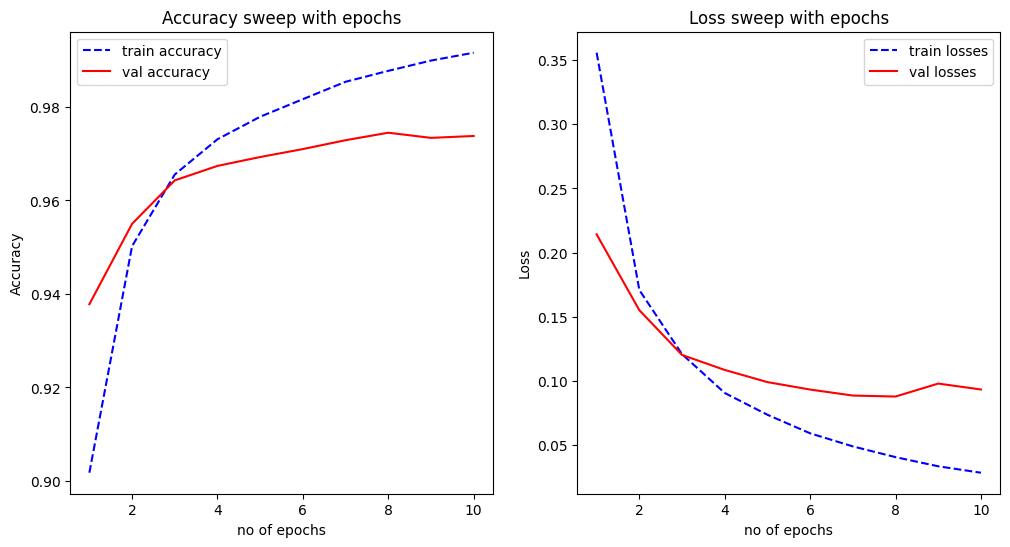

In [10]:
train_loss, train_accuracy, val_loss, val_accuracy = hist
v_epochs = range(1, len(val_accuracy)+1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(v_epochs, train_accuracy, color= 'blue', linestyle='--', label='train accuracy')
plt.plot(v_epochs, val_accuracy, color= 'red', linestyle='-', label='val accuracy')
plt.xlabel('no of epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy sweep with epochs')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(v_epochs, train_loss, color='blue', linestyle='--', label='train losses')
plt.plot(v_epochs, val_loss, color='red', linestyle='-', label='val losses')
plt.xlabel('no of epochs')
plt.ylabel('Loss')
plt.title('Loss sweep with epochs')
plt.legend()

In [11]:
sweep_configuration = {
    "method": "random",
    "name": "sweep",
    "metric": {"goal": "maximize", "name": "accuracy"},
    "parameters": {
        "batch_size": {"values": [32, 64, 128, 256, 512, 1024]},
        "hidden_layer": {"values": [1, 2, 3, 4]},
        "hidden_layer_neurons": {"values": [40, 50, 60, 70, 80]}
    },
}

sweep_id = wandb.sweep(sweep=sweep_configuration, project="5.2-MLP-classification")

def tuning():
    run = wandb.init()
    batch_size = wandb.config.batch_size
    hidden_layer = wandb.config.hidden_layer
    hidden_layer_neurons = wandb.config.hidden_layer_neurons

    # for epoch in np.arange(epochs-10, epochs):
    model = MLP_premut(permut_dataset_train, permut_dataset_val, batch_size=batch_size, learning_rate = 0.0001, max_epochs = 30, hidden_layer=hidden_layer, hidden_layer_neurons=hidden_layer_neurons, verbose= False)

    model.fit()
    hist = model.train()
    # accuracies, losses, v_epochs = regression_model.get_metric_for_each_epoch()
    accuracies = hist[3]
    losses = hist[2]
    v_epochs = range(1, 30+1)
    for accuracy, loss, epoch_count in zip(accuracies, losses, v_epochs):
        wandb.log({"accuracy": accuracy, "loss": loss})

wandb.agent(sweep_id, function=tuning, count=30)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: d4bezj7w
Sweep URL: https://wandb.ai/anushka-agrawal/5.2-MLP-classification/sweeps/d4bezj7w


wandb: Agent Starting Run: vkwk38ga with config:
wandb: 	batch_size: 128
wandb: 	hidden_layer: 1
wandb: 	hidden_layer_neurons: 70
wandb: Currently logged in as: anushka-agrawal. Use `wandb login --relogin` to force relogin


accuracy,▁▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██████████
loss,█▅▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.9489
loss,0.17571


wandb: Agent Starting Run: wq3bun7v with config:
wandb: 	batch_size: 512
wandb: 	hidden_layer: 2
wandb: 	hidden_layer_neurons: 70


accuracy,▁▅▆▇▇▇▇▇▇▇▇███████████████████
loss,█▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.9403
loss,0.21113


wandb: Agent Starting Run: x4ai37xz with config:
wandb: 	batch_size: 256
wandb: 	hidden_layer: 4
wandb: 	hidden_layer_neurons: 80


accuracy,▁▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
loss,█▄▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.9574
loss,0.1487


wandb: Agent Starting Run: qjx675rg with config:
wandb: 	batch_size: 128
wandb: 	hidden_layer: 1
wandb: 	hidden_layer_neurons: 60


accuracy,▁▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████
loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.9453
loss,0.19075


wandb: Agent Starting Run: e7kov0qp with config:
wandb: 	batch_size: 512
wandb: 	hidden_layer: 4
wandb: 	hidden_layer_neurons: 40


accuracy,▁▃▅▆▆▇▇▇▇▇▇███████████████████
loss,█▇▅▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.9232
loss,0.26606


wandb: Agent Starting Run: 8dwm7t99 with config:
wandb: 	batch_size: 64
wandb: 	hidden_layer: 1
wandb: 	hidden_layer_neurons: 50


accuracy,▁▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇███████
loss,█▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
accuracy,0.9531
loss,0.16522


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rv6vzf1c with config:
wandb: 	batch_size: 32
wandb: 	hidden_layer: 2
wandb: 	hidden_layer_neurons: 50


accuracy,▁▃▄▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇█████████
loss,█▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
accuracy,0.9659
loss,0.11508


wandb: Agent Starting Run: 54hhug9m with config:
wandb: 	batch_size: 1024
wandb: 	hidden_layer: 4
wandb: 	hidden_layer_neurons: 70


accuracy,▁▂▄▆▇▇▇▇██████████████████████
loss,██▆▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.9285
loss,0.25905


wandb: Agent Starting Run: kprmq7ec with config:
wandb: 	batch_size: 512
wandb: 	hidden_layer: 4
wandb: 	hidden_layer_neurons: 50


accuracy,▁▄▆▇▇▇▇███████████████████████
loss,█▆▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.9296
loss,0.24175


wandb: Agent Starting Run: hzxx4f64 with config:
wandb: 	batch_size: 256
wandb: 	hidden_layer: 3
wandb: 	hidden_layer_neurons: 70


accuracy,▁▅▆▇▇▇▇▇▇▇████████████████████
loss,█▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.952
loss,0.16207


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 88c59lda with config:
wandb: 	batch_size: 512
wandb: 	hidden_layer: 1
wandb: 	hidden_layer_neurons: 80


accuracy,▁▃▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇█████████████
loss,█▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.9335
loss,0.2394


wandb: Agent Starting Run: ppoze1qv with config:
wandb: 	batch_size: 128
wandb: 	hidden_layer: 3
wandb: 	hidden_layer_neurons: 40


accuracy,▁▅▆▆▇▇▇▇▇▇▇▇▇▇████████████████
loss,█▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.9486
loss,0.17669


wandb: Agent Starting Run: dqy5lwcj with config:
wandb: 	batch_size: 32
wandb: 	hidden_layer: 2
wandb: 	hidden_layer_neurons: 40


accuracy,▁▃▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██████████
loss,█▆▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
accuracy,0.9581
loss,0.13881


wandb: Agent Starting Run: 90lgmk1b with config:
wandb: 	batch_size: 512
wandb: 	hidden_layer: 1
wandb: 	hidden_layer_neurons: 50


accuracy,▁▅▆▆▇▇▇▇▇▇▇▇██████████████████
loss,█▆▄▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.9275
loss,0.26304


wandb: Agent Starting Run: ya7fij60 with config:
wandb: 	batch_size: 512
wandb: 	hidden_layer: 1
wandb: 	hidden_layer_neurons: 40


accuracy,▁▅▆▆▇▇▇▇▇▇▇███████████████████
loss,█▆▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.9231
loss,0.27736


wandb: Agent Starting Run: txnkn8us with config:
wandb: 	batch_size: 64
wandb: 	hidden_layer: 4
wandb: 	hidden_layer_neurons: 50


accuracy,▁▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇██████████████
loss,█▅▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.9595
loss,0.14246


wandb: Agent Starting Run: loyxoh11 with config:
wandb: 	batch_size: 32
wandb: 	hidden_layer: 3
wandb: 	hidden_layer_neurons: 60


accuracy,▁▃▄▄▅▅▆▆▆▇▇▇▇▇▇▇▇█████████████
loss,█▆▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.9651
loss,0.11797


wandb: Agent Starting Run: bxc5vxi4 with config:
wandb: 	batch_size: 256
wandb: 	hidden_layer: 3
wandb: 	hidden_layer_neurons: 50


accuracy,▁▄▆▆▇▇▇▇▇▇▇▇▇▇▇███████████████
loss,█▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.9447
loss,0.18757


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4gez16w3 with config:
wandb: 	batch_size: 1024
wandb: 	hidden_layer: 3
wandb: 	hidden_layer_neurons: 80


accuracy,▁▄▆▆▇▇▇███████████████████████
loss,█▇▆▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.9302
loss,0.23985


wandb: Agent Starting Run: n1ei0s03 with config:
wandb: 	batch_size: 1024
wandb: 	hidden_layer: 2
wandb: 	hidden_layer_neurons: 60


accuracy,▁▃▅▆▆▇▇▇▇▇████████████████████
loss,█▇▆▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.924
loss,0.27064


wandb: Agent Starting Run: z9bcj89b with config:
wandb: 	batch_size: 64
wandb: 	hidden_layer: 1
wandb: 	hidden_layer_neurons: 40


accuracy,▁▃▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████████
loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.9529
loss,0.17064


wandb: Agent Starting Run: 7uoxhpbp with config:
wandb: 	batch_size: 32
wandb: 	hidden_layer: 1
wandb: 	hidden_layer_neurons: 60


accuracy,▁▃▄▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇█████████
loss,█▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.9642
loss,0.12438


wandb: Agent Starting Run: q426sqne with config:
wandb: 	batch_size: 32
wandb: 	hidden_layer: 3
wandb: 	hidden_layer_neurons: 60


accuracy,▁▂▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████████
loss,█▆▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.9696
loss,0.10984


wandb: Agent Starting Run: m7im355u with config:
wandb: 	batch_size: 64
wandb: 	hidden_layer: 1
wandb: 	hidden_layer_neurons: 60


accuracy,▁▃▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇██████
loss,█▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
accuracy,0.9603
loss,0.14347


wandb: Agent Starting Run: avrq3rwx with config:
wandb: 	batch_size: 32
wandb: 	hidden_layer: 1
wandb: 	hidden_layer_neurons: 40


accuracy,▁▃▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████
loss,█▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.9584
loss,0.14354


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hqvpeo2t with config:
wandb: 	batch_size: 128
wandb: 	hidden_layer: 2
wandb: 	hidden_layer_neurons: 50
wandb: Ctrl + C detected. Stopping sweep.


The link to my wandb report:
https://api.wandb.ai/links/anushka-agrawal/57inbzzl

In [48]:
model = MLP_premut(permut_dataset_train, permut_dataset_val, hidden_layer_neurons = 80, hidden_layer = 3, batch_size=128)
model.fit()

hist = model.train()

Epoch 1/10: accuracy: 0.8477, loss: 0.5180, val_accuracy: 0.9291, val_loss: 0.2506
Epoch 2/10: accuracy: 0.9394, loss: 0.2063, val_accuracy: 0.9509, val_loss: 0.1688
Epoch 3/10: accuracy: 0.9571, loss: 0.1456, val_accuracy: 0.9571, val_loss: 0.1431
Epoch 4/10: accuracy: 0.9648, loss: 0.1167, val_accuracy: 0.9639, val_loss: 0.1228
Epoch 5/10: accuracy: 0.9701, loss: 0.0957, val_accuracy: 0.9675, val_loss: 0.1144
Epoch 6/10: accuracy: 0.9759, loss: 0.0798, val_accuracy: 0.9695, val_loss: 0.1105
Epoch 7/10: accuracy: 0.9784, loss: 0.0680, val_accuracy: 0.9680, val_loss: 0.1116
Epoch 8/10: accuracy: 0.9821, loss: 0.0567, val_accuracy: 0.9694, val_loss: 0.1093
Epoch 9/10: accuracy: 0.9845, loss: 0.0506, val_accuracy: 0.9704, val_loss: 0.1076
Epoch 10/10: accuracy: 0.9867, loss: 0.0434, val_accuracy: 0.9734, val_loss: 0.0967


In [50]:
test_dl = DataLoader(permut_dataset_test, batch_size=128, shuffle=True)

test_accuracy = 0
all_true_labels = []
all_predicted_labels = []

for x_batch, y_batch in test_dl:
    y_pred = model.model(x_batch)
    test_accuracy += (y_batch == torch.argmax(y_pred, axis=1)).sum().item()
 
    all_true_labels.extend(y_batch.tolist())

    all_predicted_labels.extend(y_pred.tolist())

test_accuracy /= len(test_dl.dataset)

class_names = [str(i) for i in range(10)]  # Assuming 10 classes
print("Test Accuracy:", test_accuracy)
# print(classification_report(all_true_labels, all_predicted_labels, target_names=class_names))

Test Accuracy: 0.9692


In [51]:
class CNN_permut(nn.Module):
    def __init__(self, train, val, batch_size=32, learning_rate = 0.1, kernel_size = 5, strides = 1, max_epochs = 10, dropout_rate = 0.5, num_classes = 10, input_channels = 1, verbose= True):
        super(CNN_permut, self).__init__()
        self.batch_size = batch_size
        self.train_dl = DataLoader(train, batch_size=self.batch_size, shuffle=True)
        self.val_dl = DataLoader(val, batch_size=self.batch_size, shuffle=True)
        self.learning_rate = learning_rate
        self.kernel_size = kernel_size
        self.strides = strides
        self.max_epochs = max_epochs
        self.dropout_rate = dropout_rate
        self.input_channels = input_channels
        self.num_classes = num_classes
        self.verbose = verbose

    def _get_features_size(self, input_channels):
        with torch.no_grad():
            x = torch.zeros(1, input_channels, 28, 28)
            x = self.model[:6](x)
            return x.view(x.size(0), -1).shape[1]

    def fit(self):
        self.model = nn.Sequential()
        self.model.add_module('conv1', nn.Conv2d(in_channels=self.input_channels, out_channels=32, kernel_size=self.kernel_size, stride=self.strides, padding=2))
        self.model.add_module('relu1', nn.ReLU())
        self.model.add_module('pool1', nn.MaxPool2d(kernel_size=2))
        self.model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=self.kernel_size, stride=self.strides, padding=2))
        self.model.add_module('relu2', nn.ReLU())
        self.model.add_module('pool2', nn.MaxPool2d(kernel_size=2))
        self.model.add_module('flatten', nn.Flatten())

        self.feature_size = self._get_features_size(self.input_channels)

        self.model.add_module('fc1', nn.Linear(self.feature_size, 1024))
        self.model.add_module('relu3', nn.ReLU())
        self.model.add_module('dropout', nn.Dropout(self.dropout_rate))
        self.model.add_module('fc2', nn.Linear(1024, self.num_classes))

        self.loss_fn = nn.CrossEntropyLoss()
        self.optimiser = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)


    def train(self):
        train_accuracy = [0.0] * self.max_epochs
        train_loss = [0.0] * self.max_epochs
        val_accuracy = [0.0] * self.max_epochs
        val_loss = [0.0] * self.max_epochs
        self.model = self.model.to(device)
        for epoch in range(self.max_epochs):
#             self.model.train()
            for x_batch, y_batch in self.train_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                y_pred = self.model(x_batch)
                loss = self.loss_fn(y_pred, y_batch)
                loss.backward()
                self.optimiser.step()
                self.optimiser.zero_grad()

                train_loss[epoch] += loss.item()*y_batch.size(0)
                train_accuracy[epoch] += np.sum((torch.argmax(y_pred, axis=1) == y_batch).cpu().numpy())

            train_loss[epoch] /= len(self.train_dl.dataset)
            train_accuracy[epoch] /= len(self.train_dl.dataset)

            self.model.eval()

            with torch.no_grad():
                for x_batch, y_batch in self.val_dl:
                    x_batch = x_batch.to(device)
                    y_batch = y_batch.to(device)
                    y_pred = self.model(x_batch)
                    loss = self.loss_fn(y_pred, y_batch)
                    val_loss[epoch] += loss.item()*y_batch.size(0)
                    val_accuracy[epoch] += np.sum((torch.argmax(y_pred, axis=1) == y_batch).cpu().numpy())
                
                val_loss[epoch] /= len(self.val_dl.dataset)
                val_accuracy[epoch] /= len(self.val_dl.dataset)
            
            if(self.verbose):
                print(f'Epoch {epoch+1}/{self.max_epochs}: accuracy: {train_accuracy[epoch]:.4f}, loss: {train_loss[epoch]:.4f}, val_accuracy: {val_accuracy[epoch]:.4f}, val_loss: {val_loss[epoch]:.4f}')

        return train_loss, train_accuracy, val_loss, val_accuracy
    
    def get_model(self):
        return self.model

In [10]:
model = CNN_permut(permut_dataset_train, permut_dataset_val, batch_size=64, max_epochs=10, learning_rate=0.0001)
# model = model.to(device)
model.fit()
hist = model.train()

Epoch 1/10: accuracy: 0.7233, loss: 0.9060, val_accuracy: 0.8739, val_loss: 0.4323
Epoch 2/10: accuracy: 0.8907, loss: 0.3659, val_accuracy: 0.9101, val_loss: 0.3032
Epoch 3/10: accuracy: 0.9224, loss: 0.2649, val_accuracy: 0.9291, val_loss: 0.2423
Epoch 4/10: accuracy: 0.9404, loss: 0.2031, val_accuracy: 0.9412, val_loss: 0.2016
Epoch 5/10: accuracy: 0.9528, loss: 0.1626, val_accuracy: 0.9546, val_loss: 0.1554
Epoch 6/10: accuracy: 0.9619, loss: 0.1317, val_accuracy: 0.9561, val_loss: 0.1492
Epoch 7/10: accuracy: 0.9676, loss: 0.1100, val_accuracy: 0.9634, val_loss: 0.1245
Epoch 8/10: accuracy: 0.9726, loss: 0.0915, val_accuracy: 0.9674, val_loss: 0.1138
Epoch 9/10: accuracy: 0.9771, loss: 0.0769, val_accuracy: 0.9645, val_loss: 0.1145
Epoch 10/10: accuracy: 0.9815, loss: 0.0634, val_accuracy: 0.9696, val_loss: 0.1001


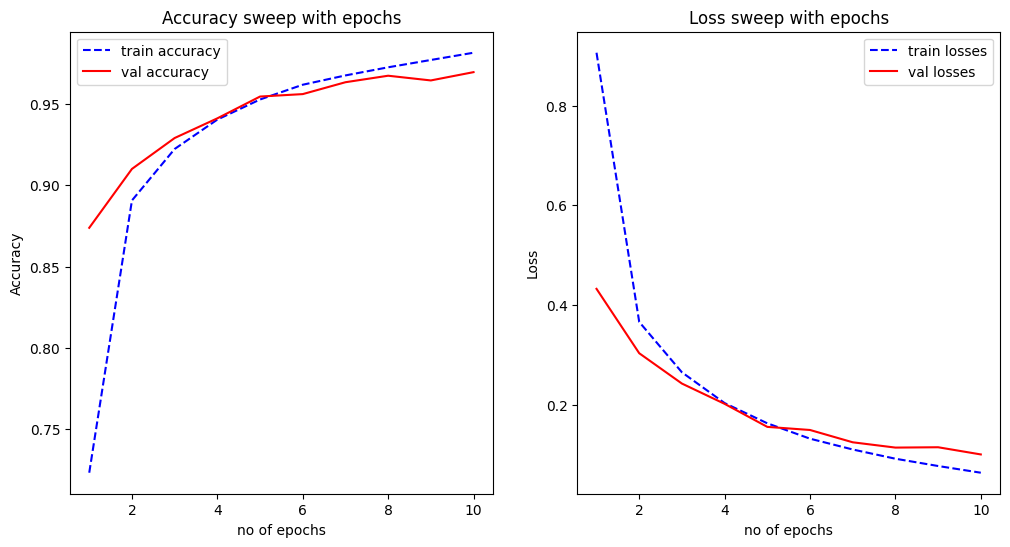

In [11]:
train_loss, train_accuracy, val_loss, val_accuracy = hist
v_epochs = range(1, len(val_accuracy)+1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(v_epochs, train_accuracy, color= 'blue', linestyle='--', label='train accuracy')
plt.plot(v_epochs, val_accuracy, color= 'red', linestyle='-', label='val accuracy')
plt.xlabel('no of epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy sweep with epochs')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(v_epochs, train_loss, color='blue', linestyle='--', label='train losses')
plt.plot(v_epochs, val_loss, color='red', linestyle='-', label='val losses')
plt.xlabel('no of epochs')
plt.ylabel('Loss')
plt.title('Loss sweep with epochs')
plt.legend()

In [12]:
sweep_configuration = {
    "method": "random",
    "name": "sweep",
    "metric": {"goal": "maximize", "name": "accuracy"},
    "parameters": {
        "batch_size": {"values": [32, 64, 128, 256, 512, 1024]},
        "dropout_rate": {"values": [0.25, 0.5, 0.75]},
        "kernel_size": {"values": [1, 3, 5]},
        "learning_rate": {"values": [0.0001, 0.0005]}
    },
}

sweep_id = wandb.sweep(sweep=sweep_configuration, project="5.2-CNN-classification")

def tuning():
    run = wandb.init()
    batch_size = wandb.config.batch_size
    dropout_rate = wandb.config.dropout_rate
    kernel_size = wandb.config.kernel_size
    lr = wandb.config.learning_rate

    # for epoch in np.arange(epochs-10, epochs):
    model = CNN_permut(permut_dataset_train, permut_dataset_val, batch_size=batch_size, max_epochs=15, learning_rate=lr, kernel_size=kernel_size, dropout_rate=dropout_rate, verbose=False)
    model.fit()
    hist = model.train()
    # accuracies, losses, v_epochs = regression_model.get_metric_for_each_epoch()
    accuracies = hist[3]
    losses = hist[2]
    v_epochs = range(1, 15+1)
    for accuracy, loss, epoch_count in zip(accuracies, losses, v_epochs):
        wandb.log({"accuracy": accuracy, "loss": loss})

wandb.agent(sweep_id, function=tuning, count=20)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: 8rfzlxat
Sweep URL: https://wandb.ai/anushka-agrawal/5.2-CNN-classification/sweeps/8rfzlxat


wandb: Agent Starting Run: 9evvej6s with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.25
wandb: 	kernel_size: 1
wandb: 	learning_rate: 0.0001
wandb: Currently logged in as: anushka-agrawal. Use `wandb login --relogin` to force relogin


accuracy,▁▃▄▄▄▅▅▆▆▇▇▇███
loss,█▆▅▅▄▄▄▃▃▂▂▂▁▁▁
accuracy,0.8916
loss,0.34004


wandb: Agent Starting Run: 8ag197y8 with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.5
wandb: 	kernel_size: 1
wandb: 	learning_rate: 0.0001


accuracy,▁▃▄▄▄▆▆▇▇▇▇████
loss,█▆▅▄▄▃▃▂▂▂▂▁▁▁▁
accuracy,0.8917
loss,0.3439


wandb: Agent Starting Run: s7jg4von with config:
wandb: 	batch_size: 1024
wandb: 	dropout_rate: 0.75
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.0005


accuracy,▁▄▅▅▆▆▇▇▇▇█████
loss,█▅▄▄▃▃▂▂▂▁▁▁▁▁▁
accuracy,0.9658
loss,0.1127


wandb: Agent Starting Run: aqryssrr with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.75
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0001


accuracy,▁▄▆▇▇▇▇████████
loss,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁
accuracy,0.9709
loss,0.10412


wandb: Agent Starting Run: ptk0q8m1 with config:
wandb: 	batch_size: 1024
wandb: 	dropout_rate: 0.75
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0001


accuracy,▁▃▅▆▆▇▇▇▇██████
loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁
accuracy,0.9183
loss,0.2763


wandb: Agent Starting Run: xfub9f0d with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.75
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.0001


accuracy,▁▄▅▅▆▆▇▇▇▇█████
loss,█▅▄▃▃▃▂▂▂▂▁▁▁▁▁
accuracy,0.9541
loss,0.1497


wandb: Agent Starting Run: wcjhi9s5 with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.75
wandb: 	kernel_size: 1
wandb: 	learning_rate: 0.0001


accuracy,▁▃▄▅▅▆▆▆▆▇▇▇▇██
loss,█▄▄▃▃▃▃▂▂▂▂▂▁▁▁
accuracy,0.8686
loss,0.41469


wandb: Agent Starting Run: 1m6b9y84 with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.5
wandb: 	kernel_size: 1
wandb: 	learning_rate: 0.0001


accuracy,▁▅▆▆▆▇▆▇▇▇▇▇███
loss,█▄▃▃▂▂▂▂▂▂▁▁▁▁▁
accuracy,0.8382
loss,0.50985


wandb: Agent Starting Run: 8imzny7h with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.5
wandb: 	kernel_size: 1
wandb: 	learning_rate: 0.0005


accuracy,▁▄▅▆▆▇▇▇█▇█████
loss,█▅▄▃▃▂▂▂▁▁▁▁▁▁▁
accuracy,0.9086
loss,0.28419


wandb: Agent Starting Run: p8k5jyex with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.5
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.0001


accuracy,▁▄▅▅▆▆▇▆▇▇▇▇███
loss,█▅▄▃▃▃▂▂▂▂▂▁▁▁▁
accuracy,0.9576
loss,0.14448


wandb: Agent Starting Run: xssyksi7 with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.75
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0001


accuracy,▁▄▅▆▆▇▇▇▇██████
loss,█▅▄▃▃▂▂▂▂▁▁▁▁▁▁
accuracy,0.9693
loss,0.10393


wandb: Agent Starting Run: kayti6ap with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.75
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0005


accuracy,▁▄▆▇▇██████▇███
loss,█▅▃▂▂▁▁▁▁▁▁▂▁▂▂
accuracy,0.9729
loss,0.11023


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2lav0yq7 with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.25
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.0001


accuracy,▁▃▅▆▆▇▇▇███████
loss,█▆▄▃▃▂▁▂▁▁▁▁▁▁▁
accuracy,0.9736
loss,0.10046


wandb: Agent Starting Run: c21mlhgy with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.75
wandb: 	kernel_size: 1
wandb: 	learning_rate: 0.0005


accuracy,▁▅▅▆▇▇▇▇███████
loss,█▄▄▃▂▂▂▂▁▁▁▁▁▁▁
accuracy,0.9052
loss,0.29889


wandb: Agent Starting Run: 1ojb97l7 with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.5
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.0005


accuracy,▁▅▆▇▇▇▇█████▇██
loss,█▄▃▂▂▁▁▁▂▂▂▂▂▂▂
accuracy,0.9717
loss,0.13364


wandb: Agent Starting Run: w6is95yj with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.75
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0001


accuracy,▁▄▅▅▆▇▇▇▇██████
loss,█▅▄▃▃▂▂▂▂▁▁▁▁▁▁
accuracy,0.9705
loss,0.09719


wandb: Agent Starting Run: scgqpphl with config:
wandb: 	batch_size: 1024
wandb: 	dropout_rate: 0.5
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.0005


accuracy,▁▄▅▆▆▇▇▇▇▇█████
loss,█▅▄▃▃▂▂▂▂▁▁▁▁▁▁
accuracy,0.9642
loss,0.12383


wandb: Agent Starting Run: qrn36w27 with config:
wandb: 	batch_size: 512
wandb: 	dropout_rate: 0.5
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0001


accuracy,▁▄▅▅▆▆▇▇▇▇▇████
loss,█▅▃▃▃▂▂▂▂▂▁▁▁▁▁
accuracy,0.9412
loss,0.20911


wandb: Agent Starting Run: pcywrx2d with config:
wandb: 	batch_size: 1024
wandb: 	dropout_rate: 0.75
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0005


accuracy,▁▄▅▆▆▇▇▇▇▇█████
loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁
accuracy,0.9648
loss,0.11287


wandb: Agent Starting Run: y6z55jdw with config:
wandb: 	batch_size: 1024
wandb: 	dropout_rate: 0.75
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.0005


accuracy,▁▄▅▆▆▇▇▇▇██████
loss,█▅▄▃▃▂▂▂▂▁▁▁▁▁▁
accuracy,0.9658
loss,0.11456


The link to my wand report for logging loss and accuracy:
https://api.wandb.ai/links/anushka-agrawal/5cnbtkrf

In [52]:
model = CNN_permut(permut_dataset_train, permut_dataset_val, batch_size=128, max_epochs=10, learning_rate=0.0001, dropout_rate = 0.75, kernel_size = 5)
# model = model.to(device)
model.fit()
hist = model.train()

Epoch 1/10: accuracy: 0.5982, loss: 1.2661, val_accuracy: 0.8420, val_loss: 0.5821
Epoch 2/10: accuracy: 0.8606, loss: 0.4692, val_accuracy: 0.8900, val_loss: 0.3773
Epoch 3/10: accuracy: 0.8977, loss: 0.3498, val_accuracy: 0.9094, val_loss: 0.3056
Epoch 4/10: accuracy: 0.9182, loss: 0.2810, val_accuracy: 0.9285, val_loss: 0.2542
Epoch 5/10: accuracy: 0.9326, loss: 0.2316, val_accuracy: 0.9374, val_loss: 0.2177
Epoch 6/10: accuracy: 0.9418, loss: 0.1965, val_accuracy: 0.9456, val_loss: 0.1881
Epoch 7/10: accuracy: 0.9519, loss: 0.1689, val_accuracy: 0.9459, val_loss: 0.1755
Epoch 8/10: accuracy: 0.9573, loss: 0.1474, val_accuracy: 0.9535, val_loss: 0.1591
Epoch 9/10: accuracy: 0.9626, loss: 0.1290, val_accuracy: 0.9573, val_loss: 0.1455
Epoch 10/10: accuracy: 0.9674, loss: 0.1114, val_accuracy: 0.9600, val_loss: 0.1314


In [54]:
test_dl = DataLoader(permut_dataset_test, batch_size=128, shuffle=True)

test_accuracy = 0
all_true_labels = []
all_predicted_labels = []

for x_batch, y_batch in test_dl:
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    y_pred = model.model(x_batch)
    test_accuracy += (y_batch == torch.argmax(y_pred, axis=1)).sum().item()
 
    all_true_labels.extend(y_batch.tolist())

    all_predicted_labels.extend(y_pred.tolist())

test_accuracy /= len(test_dl.dataset)

class_names = [str(i) for i in range(10)]  # Assuming 10 classes
print("Test Accuracy:", test_accuracy)
# print(classification_report(all_true_labels, all_predicted_labels, target_names=class_names))

Test Accuracy: 0.9639


## 5.3 Analysis

### 1. MLP vs. CNN Performance

In this analysis, we compare the performances of Multilayer Perceptron (MLP) and Convolutional Neural Network (CNN) models for both the Double-MNIST and Permuted-MNIST datasets.

#### Multi-MNIST Dataset:

- **MLP**: The MLP model for Double-MNIST performs okayish as it struggles to capture spatial relationships in digits. It relies on the flattening of the input image, treating it as a vector, and this affects its ability to recognize two distinct digits effectively. The model's accuracy on the test set is limited by its architecture. We get a max accuracy of 40% using this model on double-MNIST dataset.

- **CNN**: In contrast, the CNN model performs better on the Double-MNIST dataset. Its ability to learn hierarchical features and spatial information makes it highly suitable for recognizing and classifying two distinct digits within an image. The CNN achieves relatively high accuracy on the test set compared to MLP. It has a accuracy of 77% for this dataset.

#### Permuted-MNIST Dataset:

- **MLP**: The MLP on the Permuted-MNIST dataset performs really well. However, the task of recognizing digits in permuted sequences is inherently challenging. But still it gives an accuracy close to 97% on the dataset which is really good.

- **CNN**: The CNN model performs on Permuted-MNIST.  The MLP slightly outperforms the CNN on this dataset as spatial dependency do not matter a lot due to shuffling. It gives an accuracy of 96.3% on this dataset

### 2. Observations and Challenges

**Multi-MNIST Dataset**:

- A notable challenge with the Multi-MNIST dataset is the need for the model to understand the spatial layout of two digits in a single image. The MLP, due to its flat structure, faces limitations in this regard. The CNN, with its convolutional layers, overcomes this challenge more effectively.

**Permuted-MNIST Dataset**:

- The challenge here is to recognize digits when the pixel order is shuffled. Both models will face difficulties, but MLP outperforms CNN slightly as the spatial dependencies are reduced due to shuffling of the data.

### 3. Potential for Overfitting

In the context of overfitting, CNNs tend to have the potential for overfitting when compared to MLPs. This is especially true when dealing with smaller datasets. Training vs. validation loss/accuracy plots often show that CNNs can achieve lower training losses, but their validation loss might not decrease as rapidly, indicating overfitting. On the other hand, MLPs, while generally simpler, might not overfit as easily due to fewer parameters.

The choice between CNN and MLP should be made based on the specific dataset and task, as well as the amount of available data. Proper regularization techniques, such as dropout, can help mitigate overfitting in CNNs.

In conclusion, the selection between MLP and CNN models depends on the nature of the dataset and the task. CNNs excel in tasks that involve spatial features and complex patterns, but they may require careful handling to prevent overfitting. MLPs can be more suitable for simpler tasks with structured data or when dataset size is limited.
